In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py

In [2]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  196


['permutations/total_ring_mass=5.999999999999995e-10_radial_width=0.0005_shear_viscosity=5.1037628395577705e-11_sim_id=8_timesteps_per_output=19_',
 'permutations/total_ring_mass=2.0730643767553322e-08_radial_width=0.0005_shear_viscosity=3.0000000000000036e-10_sim_id=153_timesteps_per_output=114_',
 'permutations/total_ring_mass=2.0730643767553322e-08_radial_width=0.0005_shear_viscosity=1.2373879148704033e-11_sim_id=144_timesteps_per_output=2764_',
 'permutations/total_ring_mass=1.736559674830051e-09_radial_width=0.0005_shear_viscosity=1.4771647895120244e-10_sim_id=53_timesteps_per_output=19_',
 'permutations/total_ring_mass=6.000000000000007e-08_radial_width=0.0005_shear_viscosity=7.273386051246977e-11_sim_id=191_timesteps_per_output=1361_']

In [3]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import pandas as pd

In [4]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('_timesteps_per_output=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/total_ring_mass=5.999999999999995...
1       1  permutations/total_ring_mass=5.999999999999995...
2       2  permutations/total_ring_mass=5.999999999999995...
3       3  permutations/total_ring_mass=5.999999999999995...
4       4  permutations/total_ring_mass=5.999999999999995...

In [5]:
#set power laws for ringlet's dynamical timescale = time for e_prime to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 1.65e4
mass_power_law = 1.0
viscosity_power_law = -1.0
width_power_law = -0.33

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:56: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:58: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:68: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)


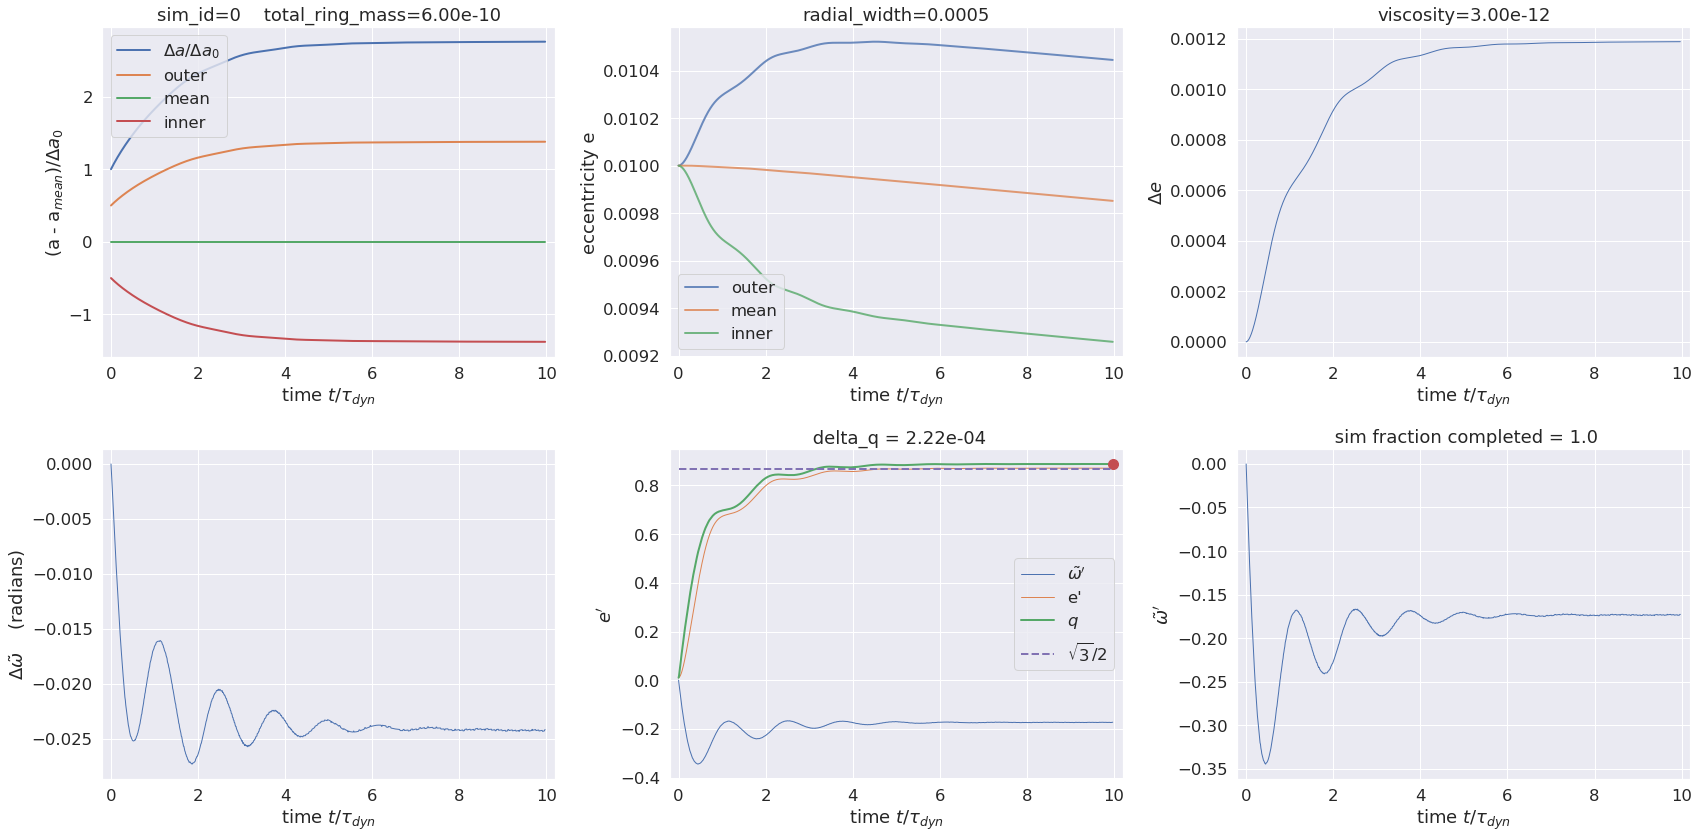

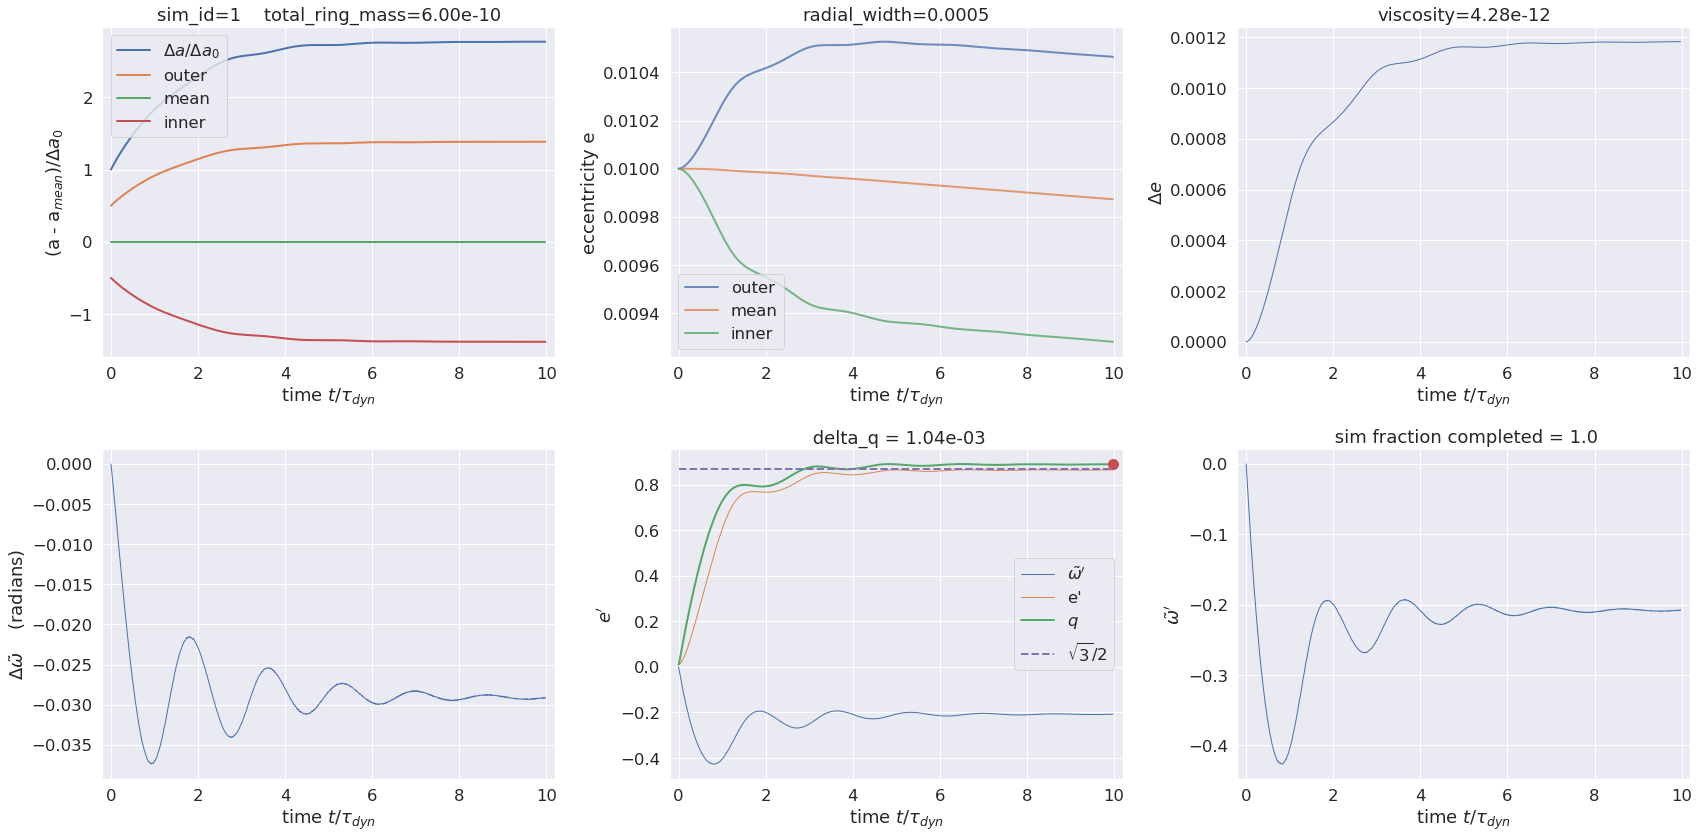

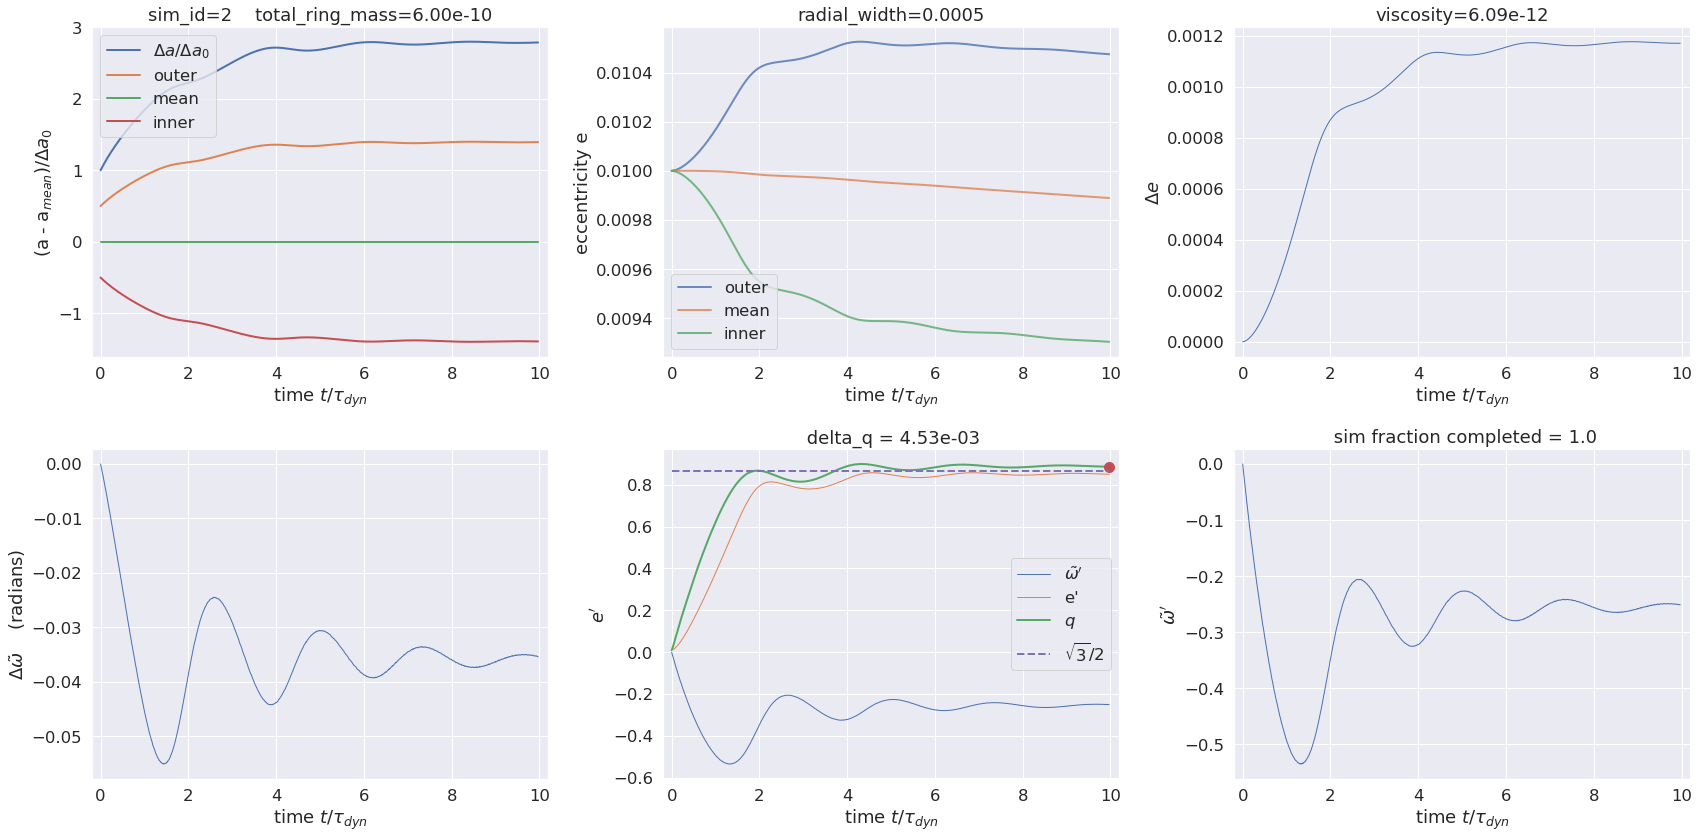

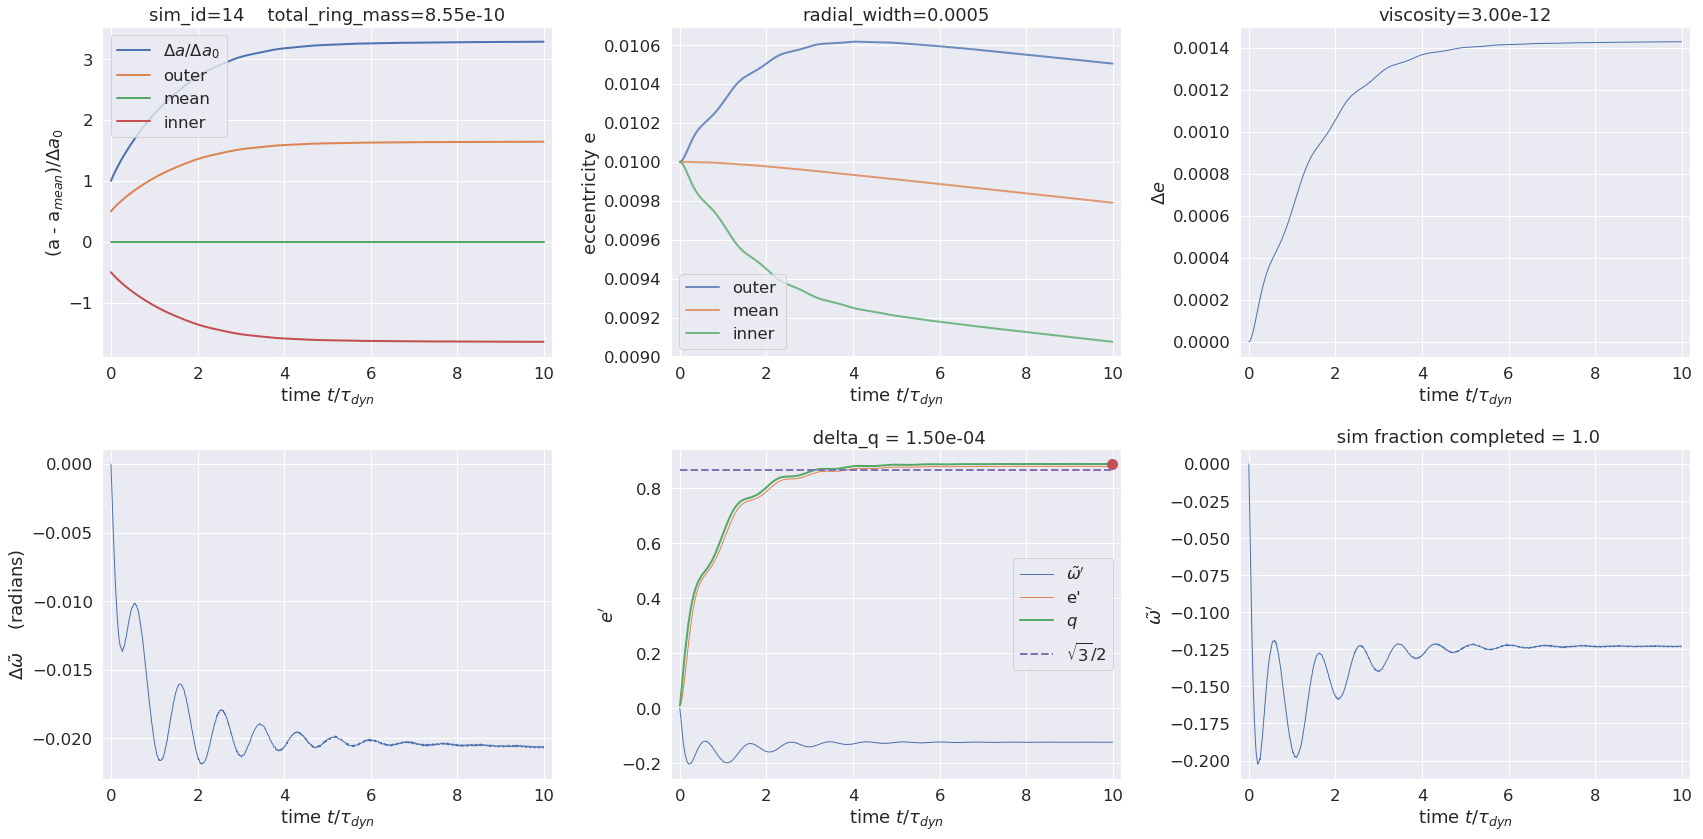

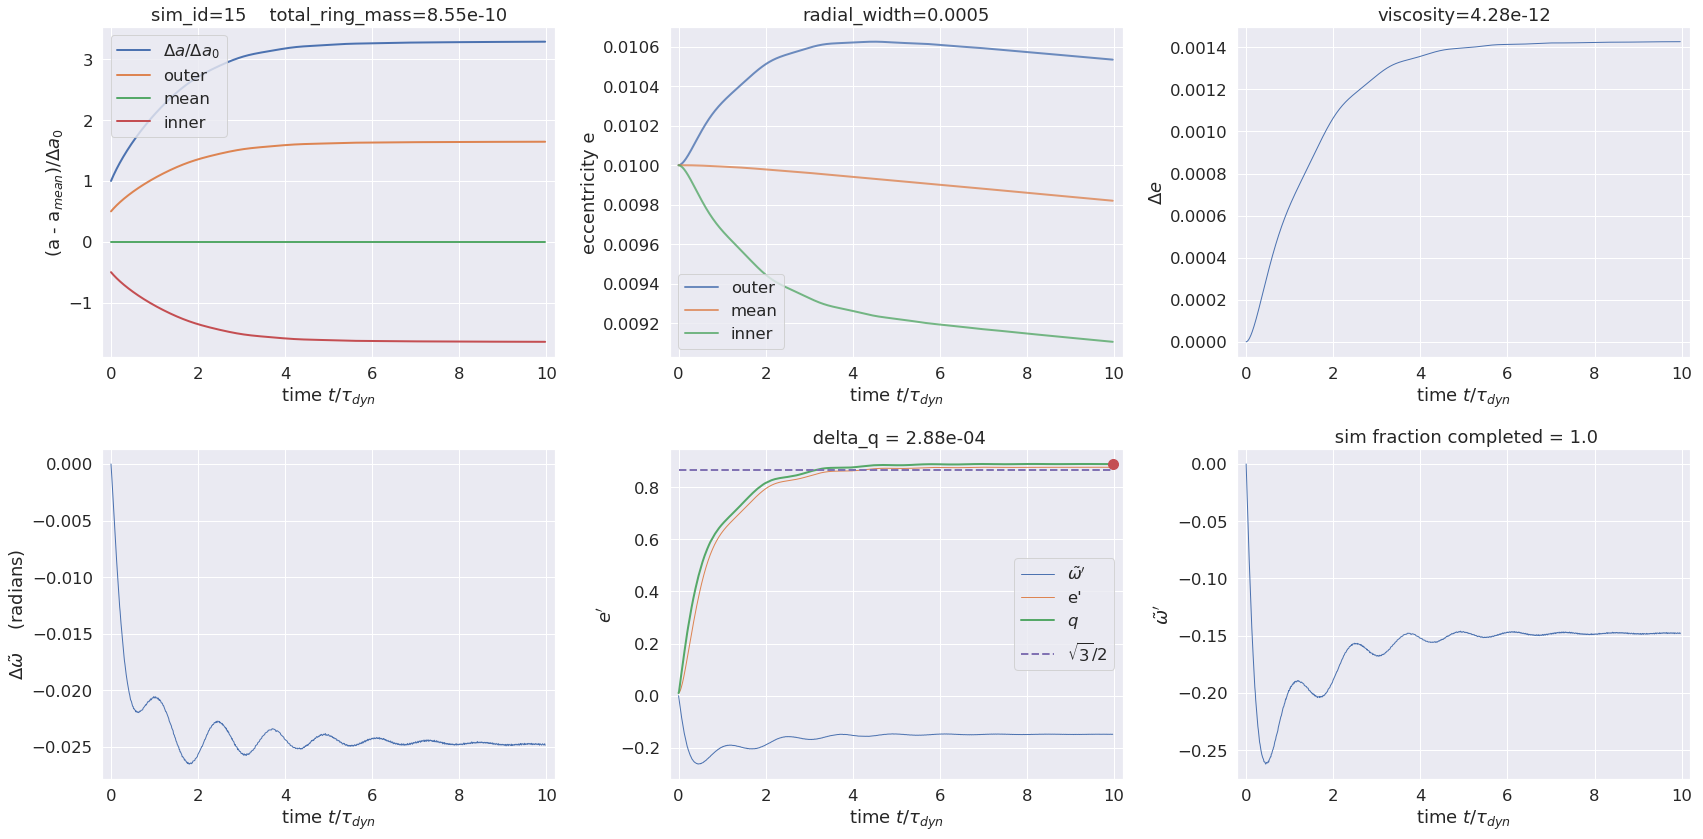

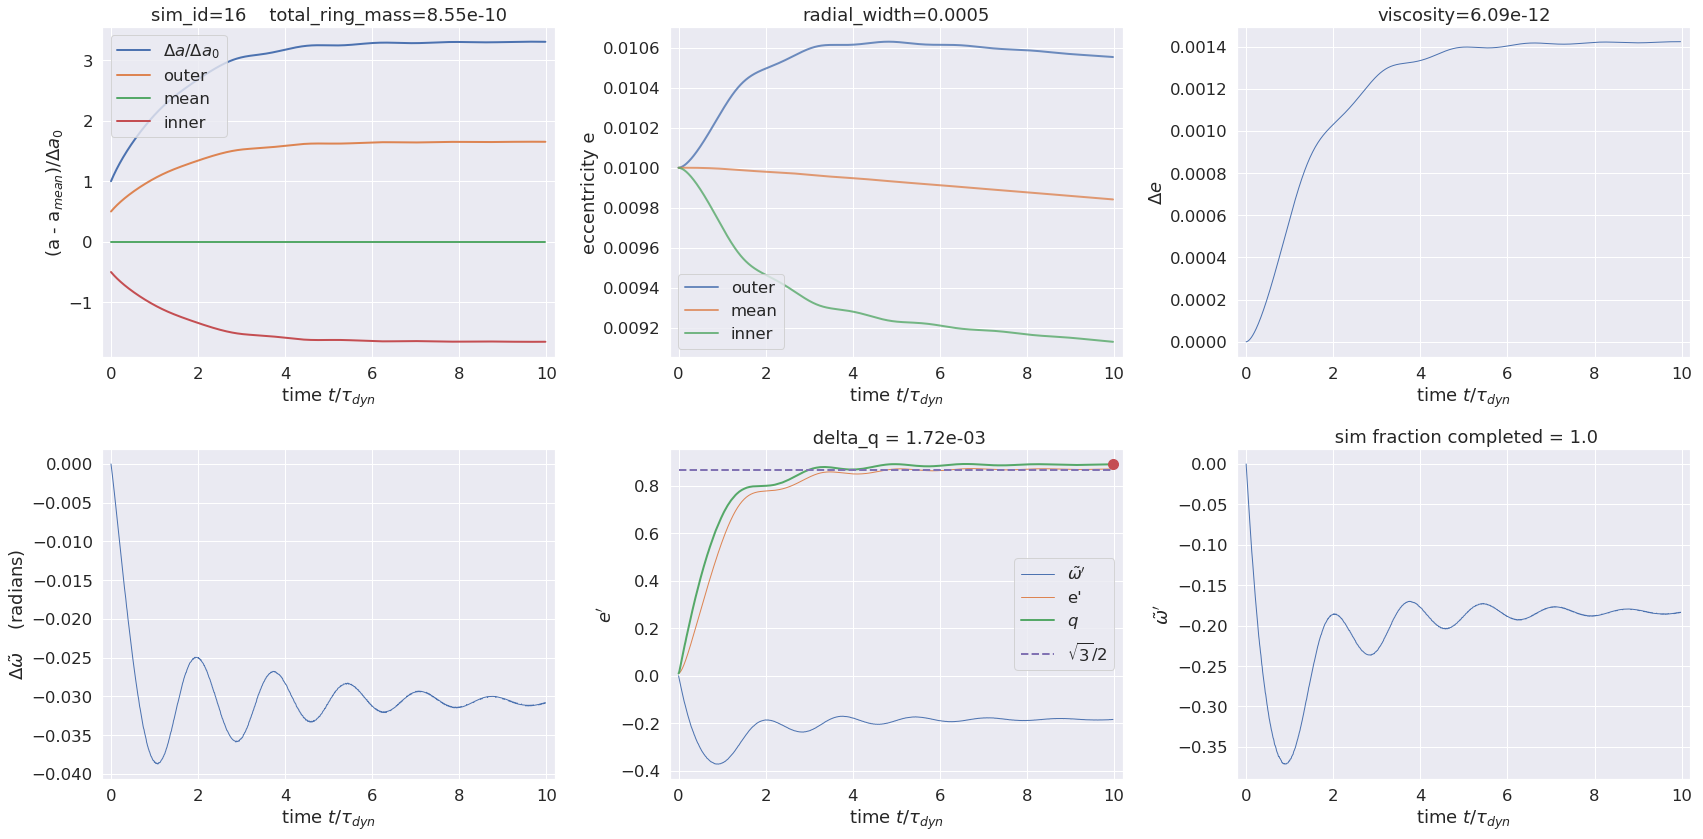

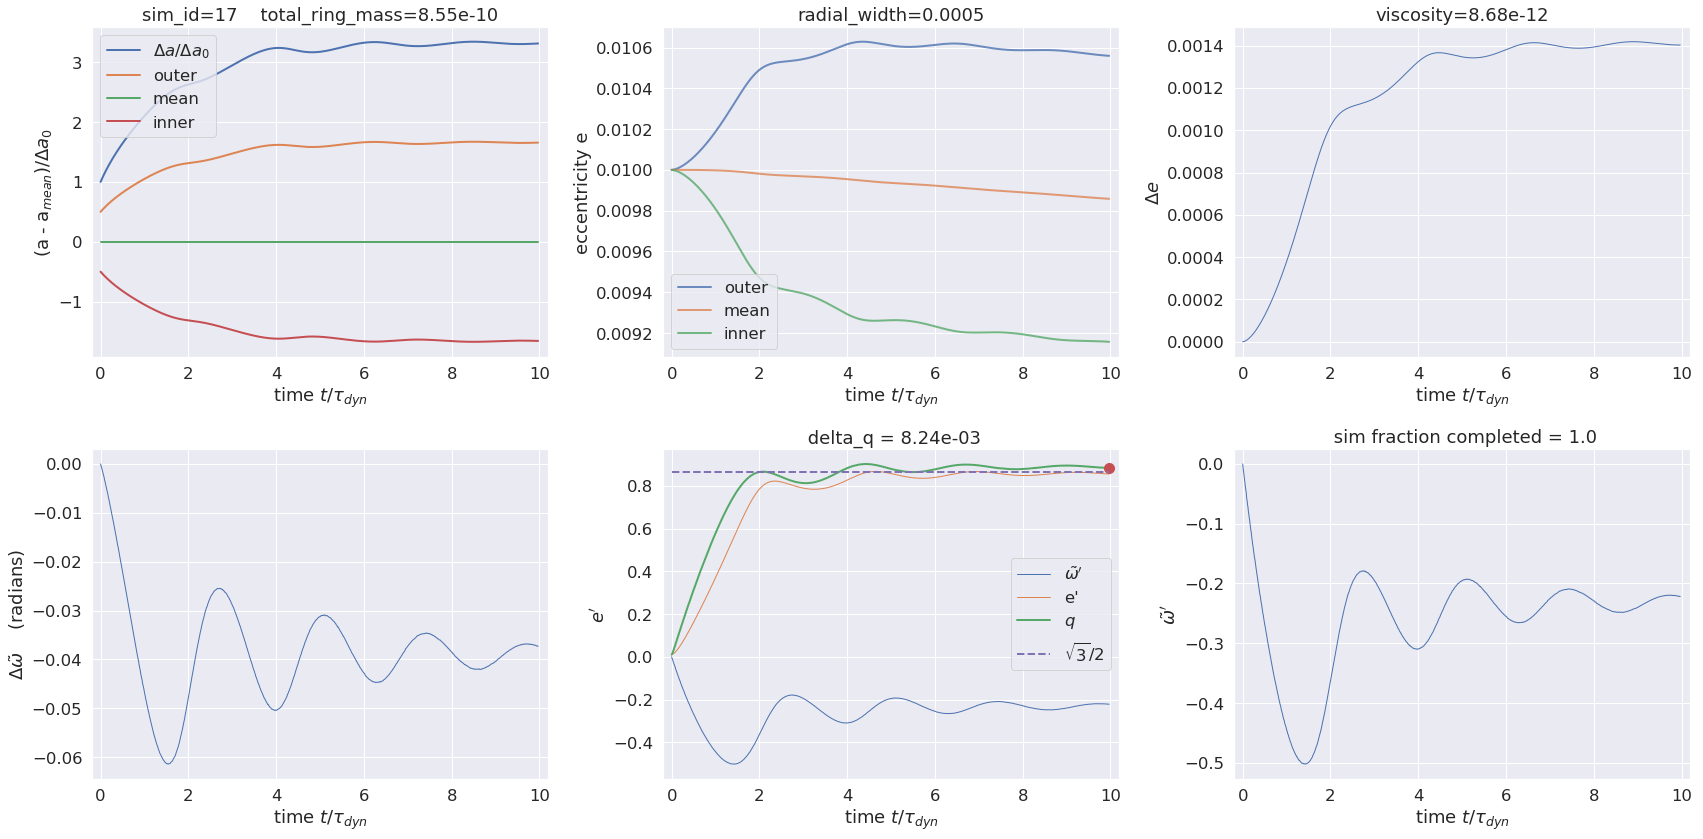

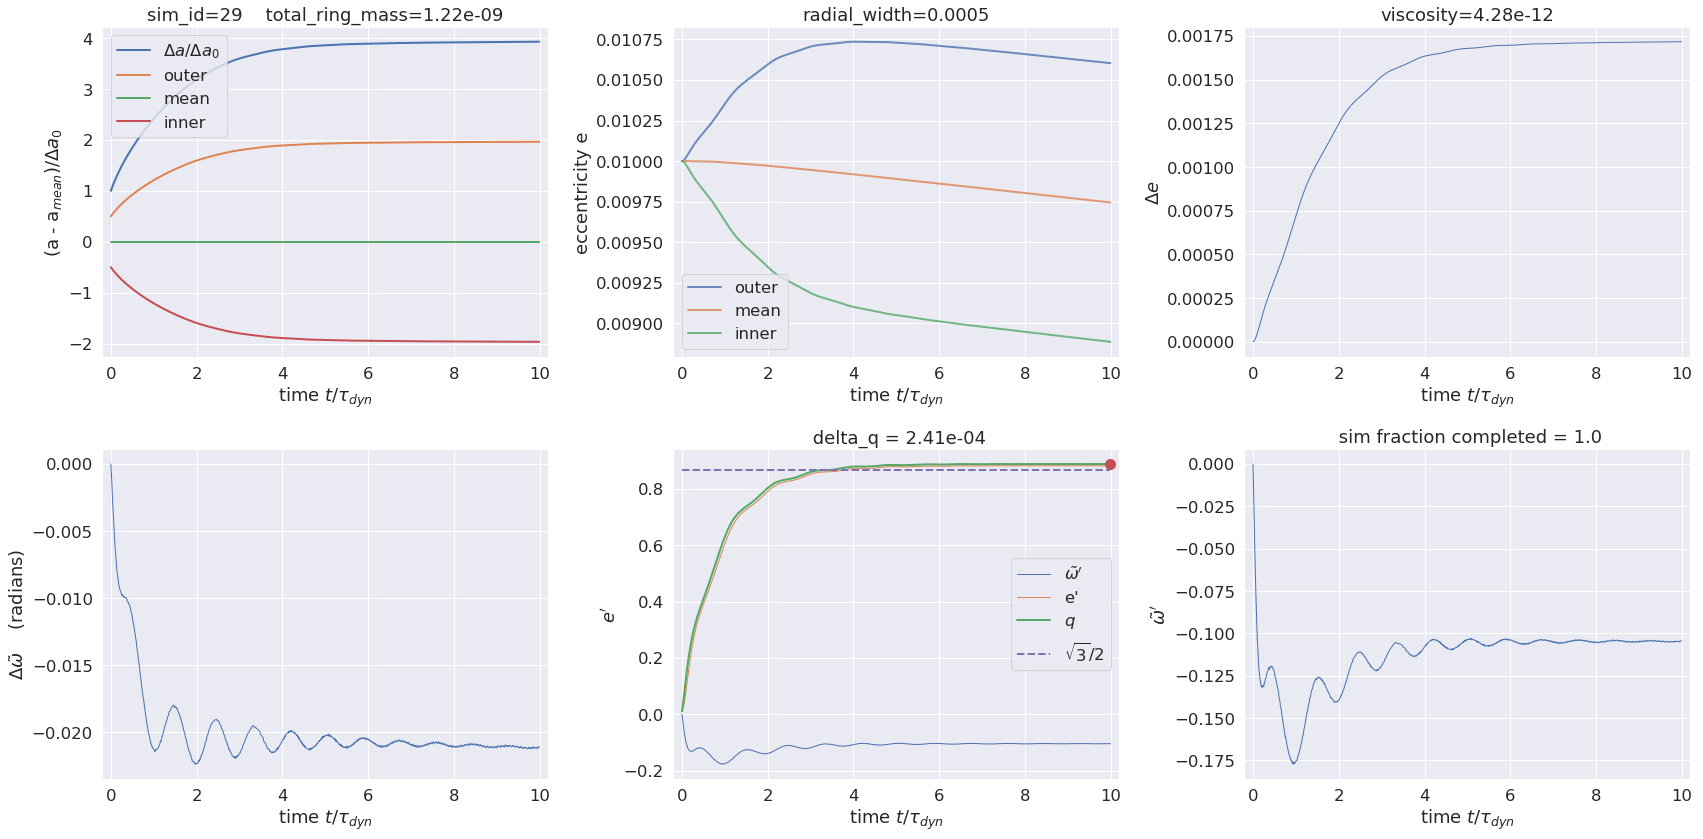

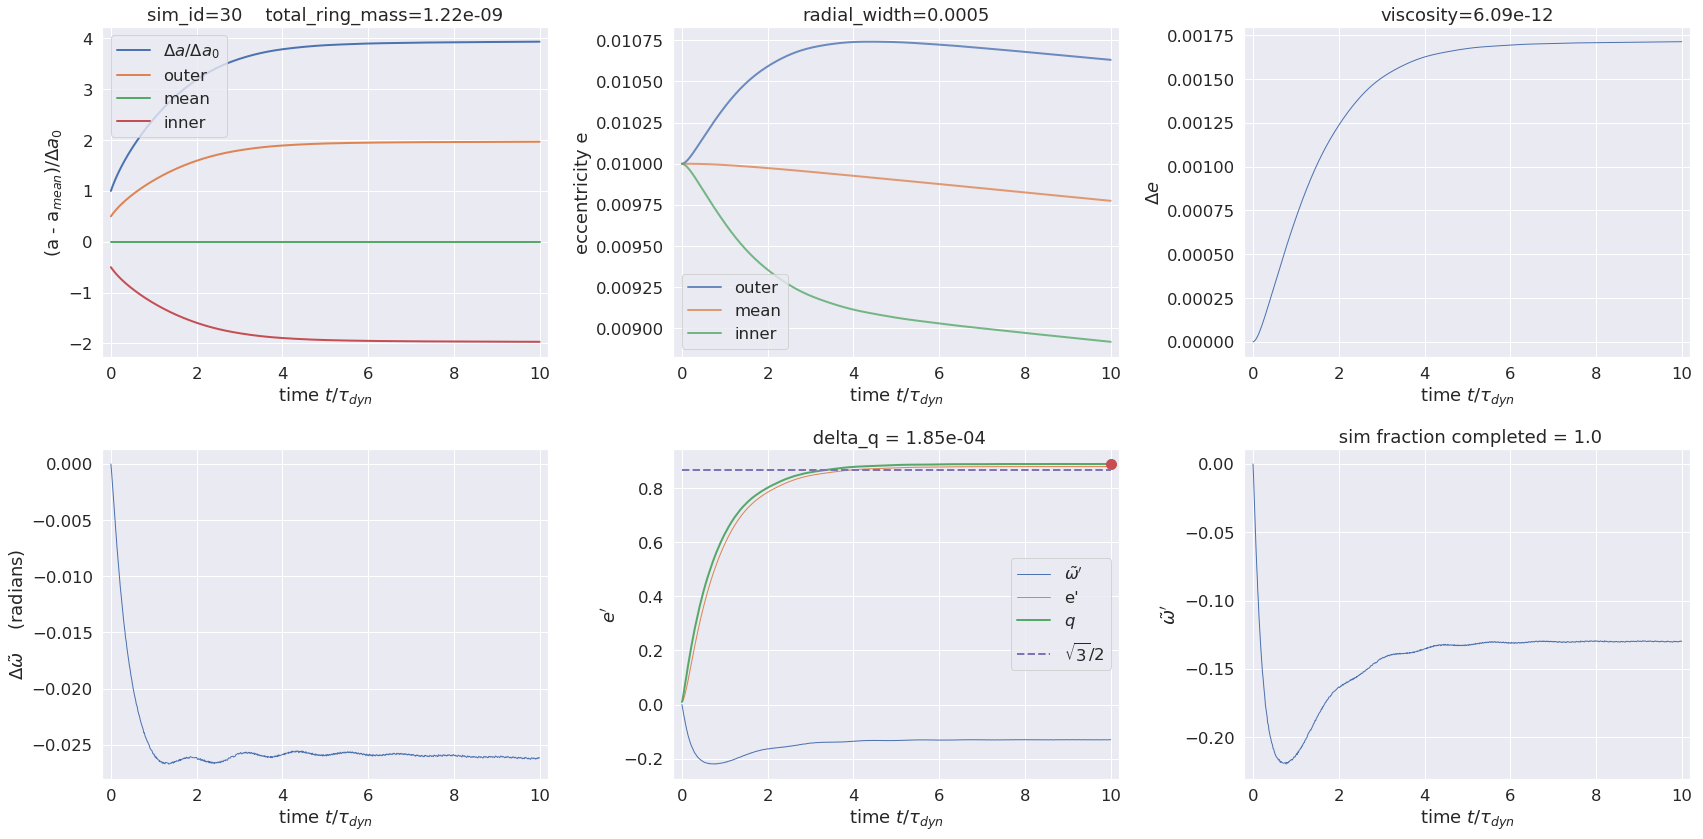

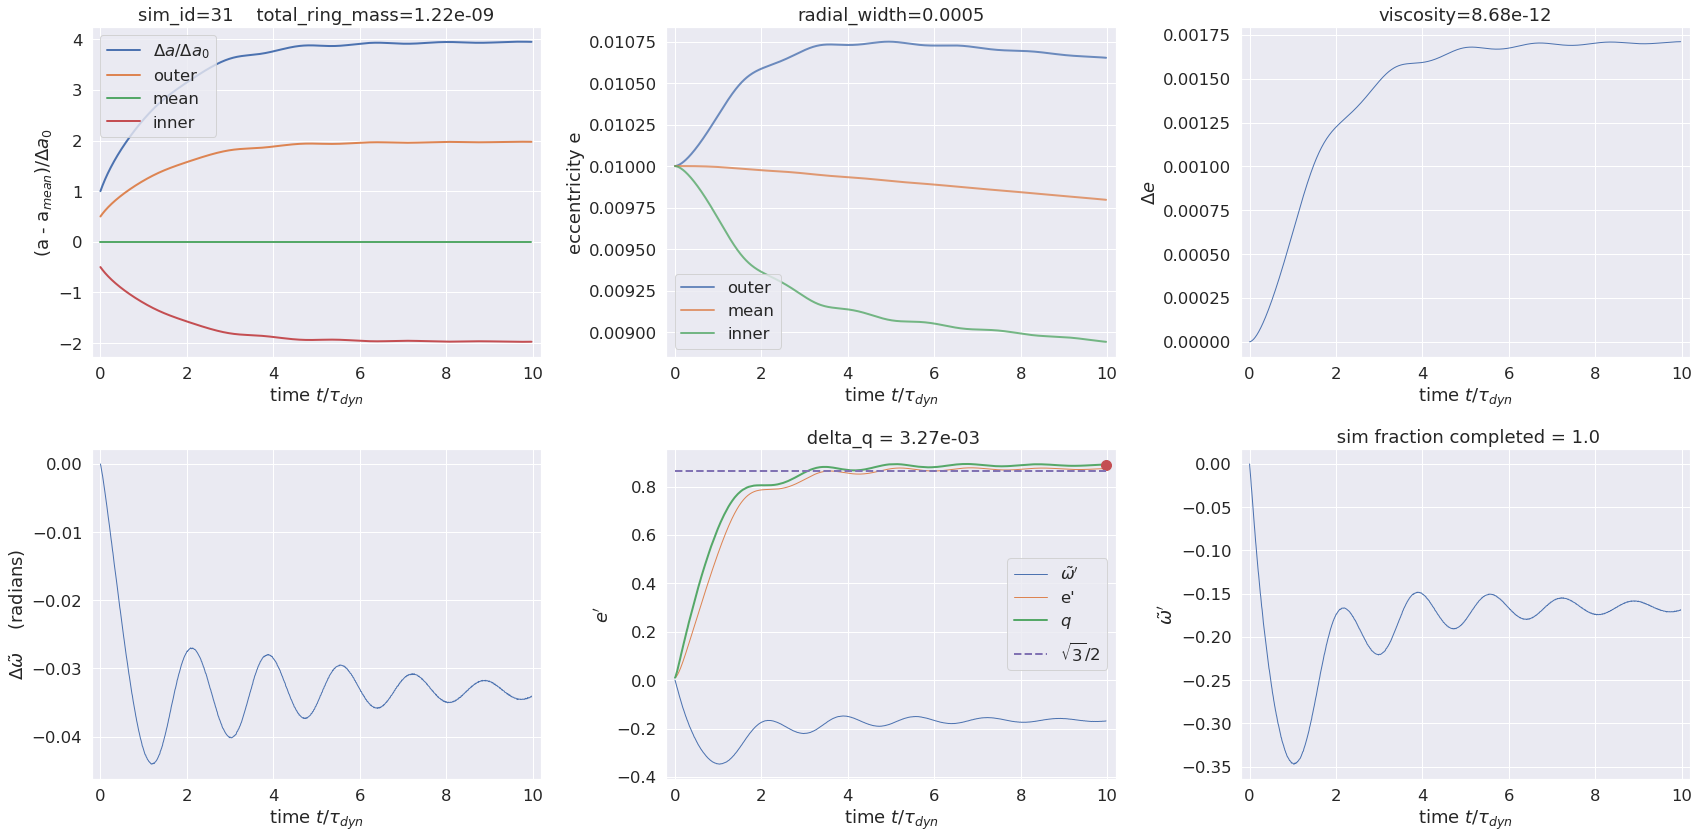

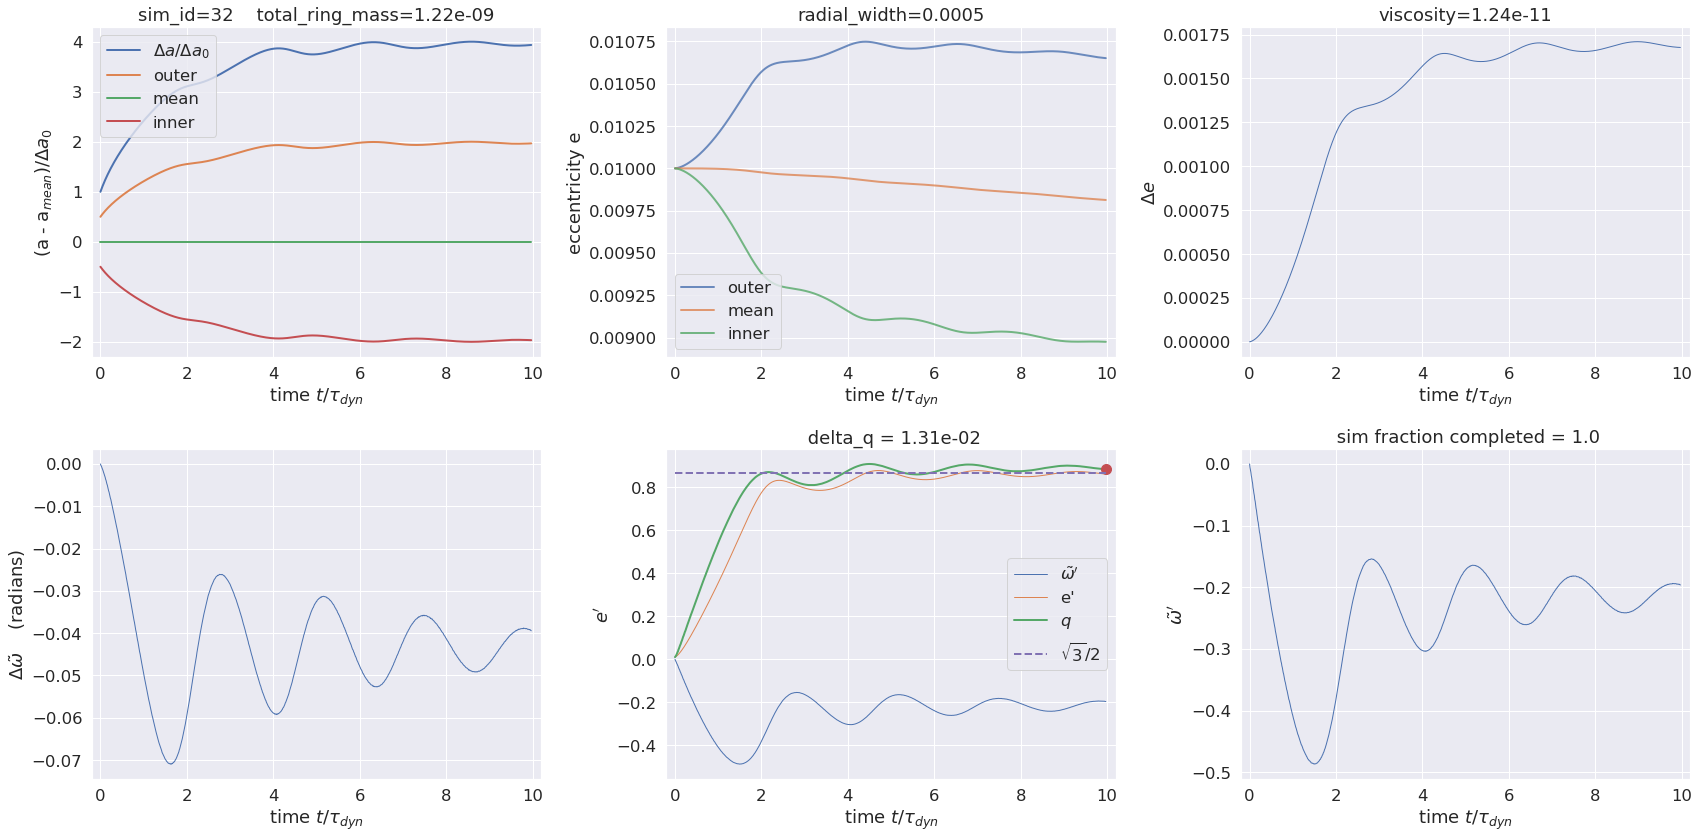

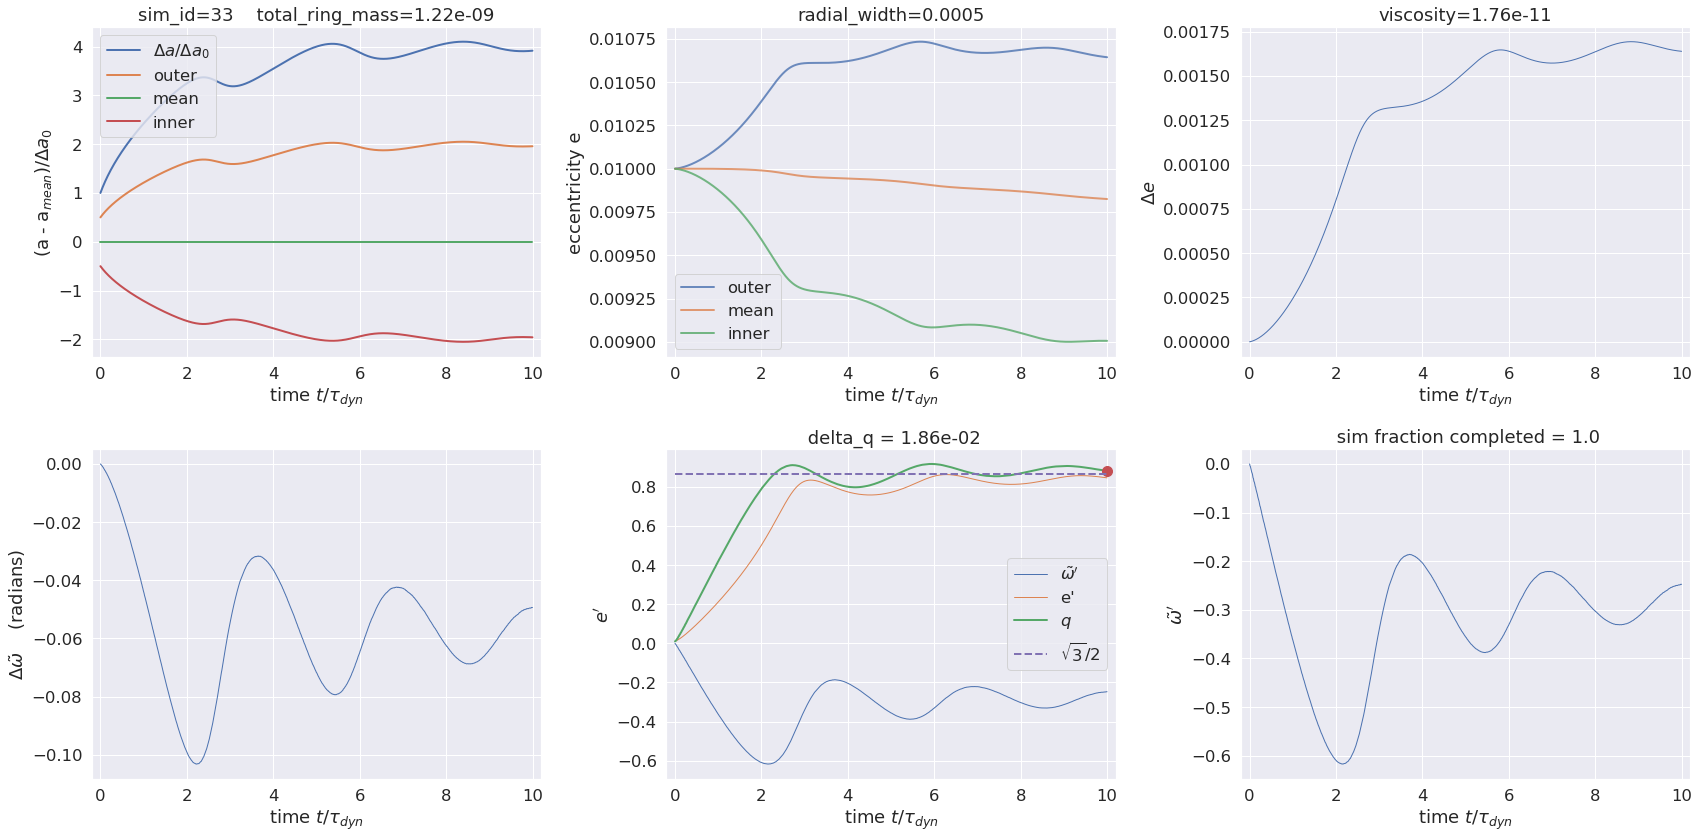

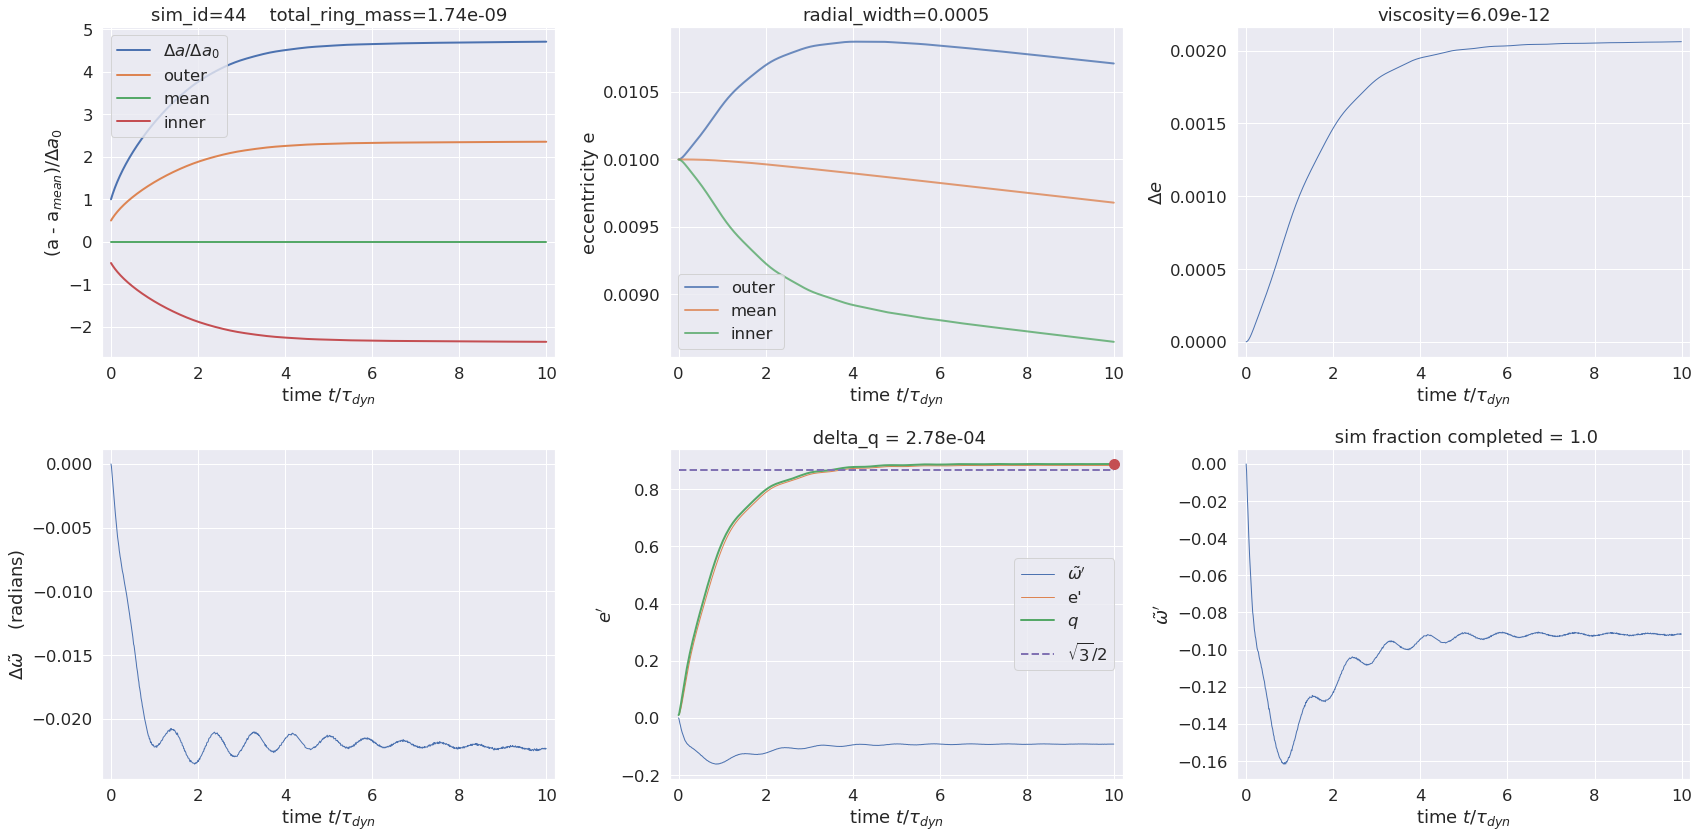

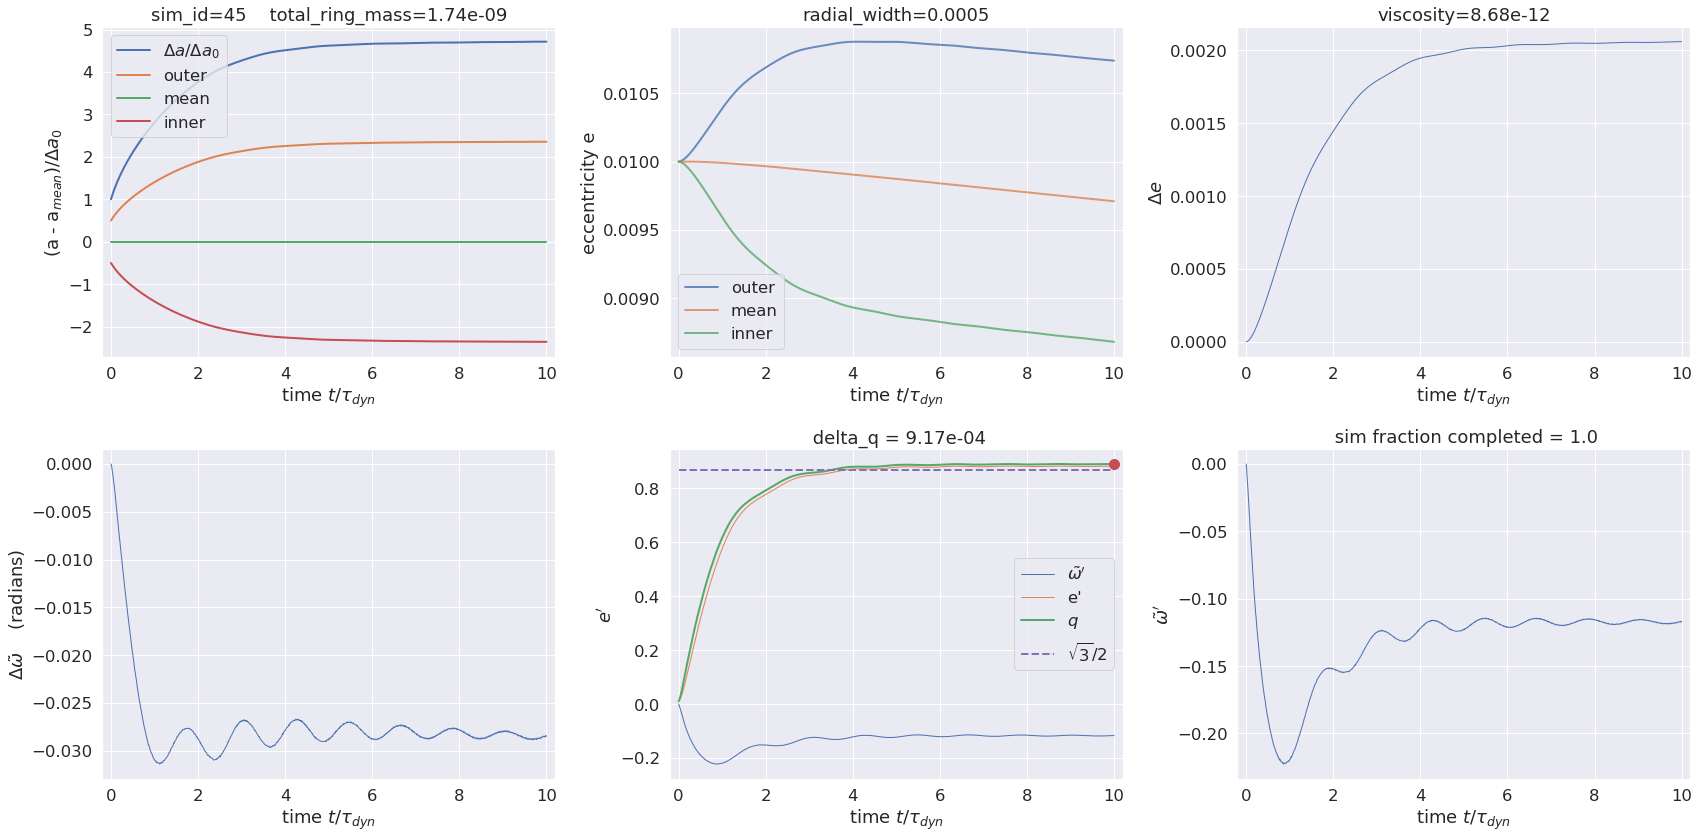

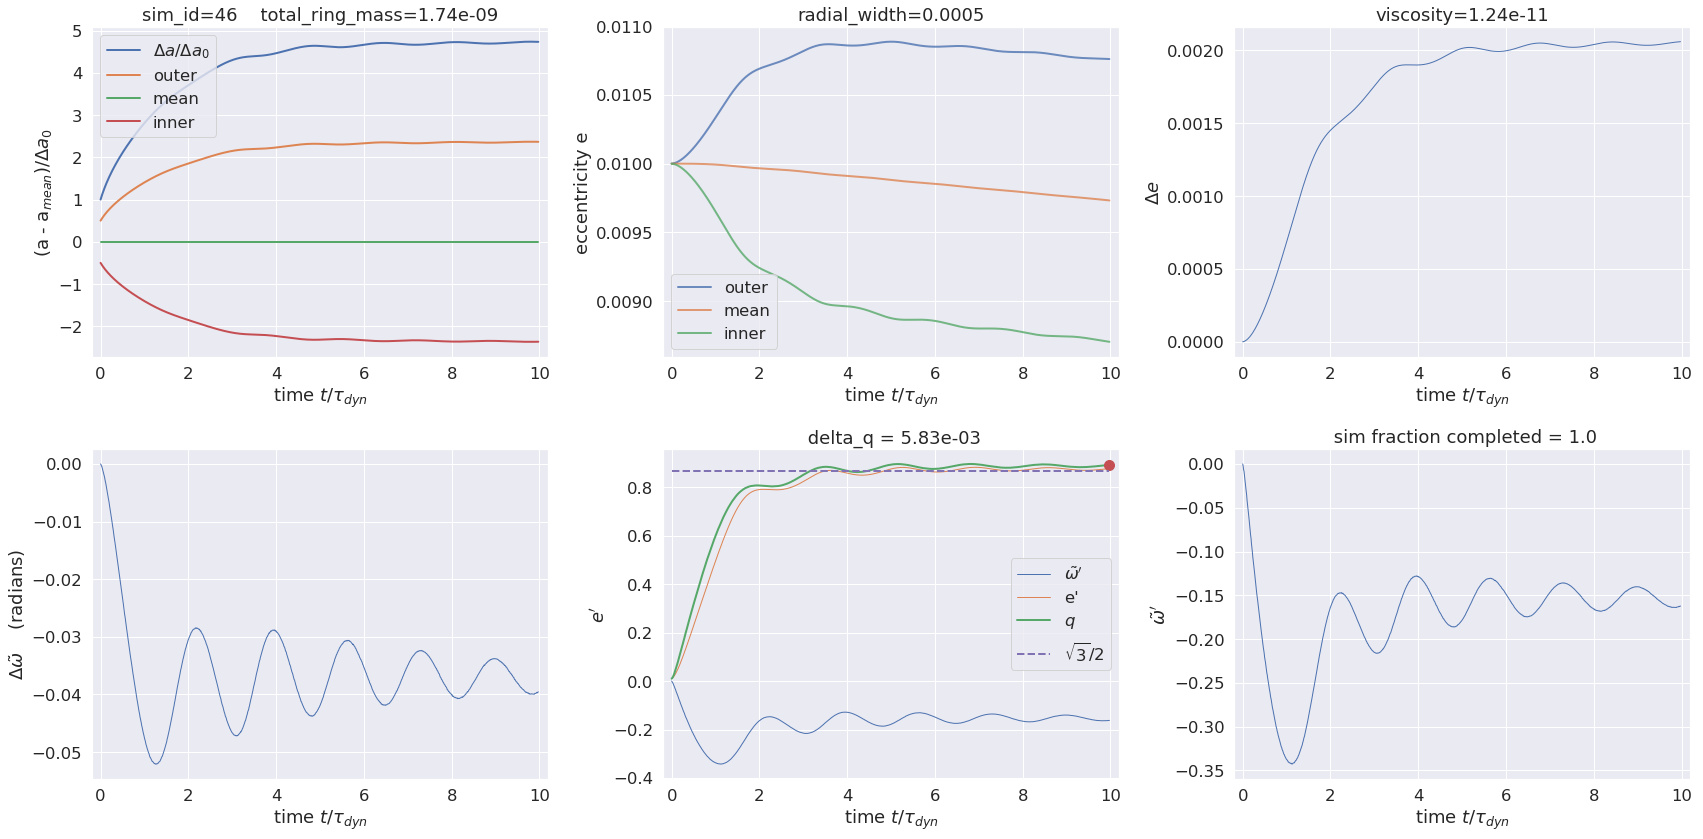

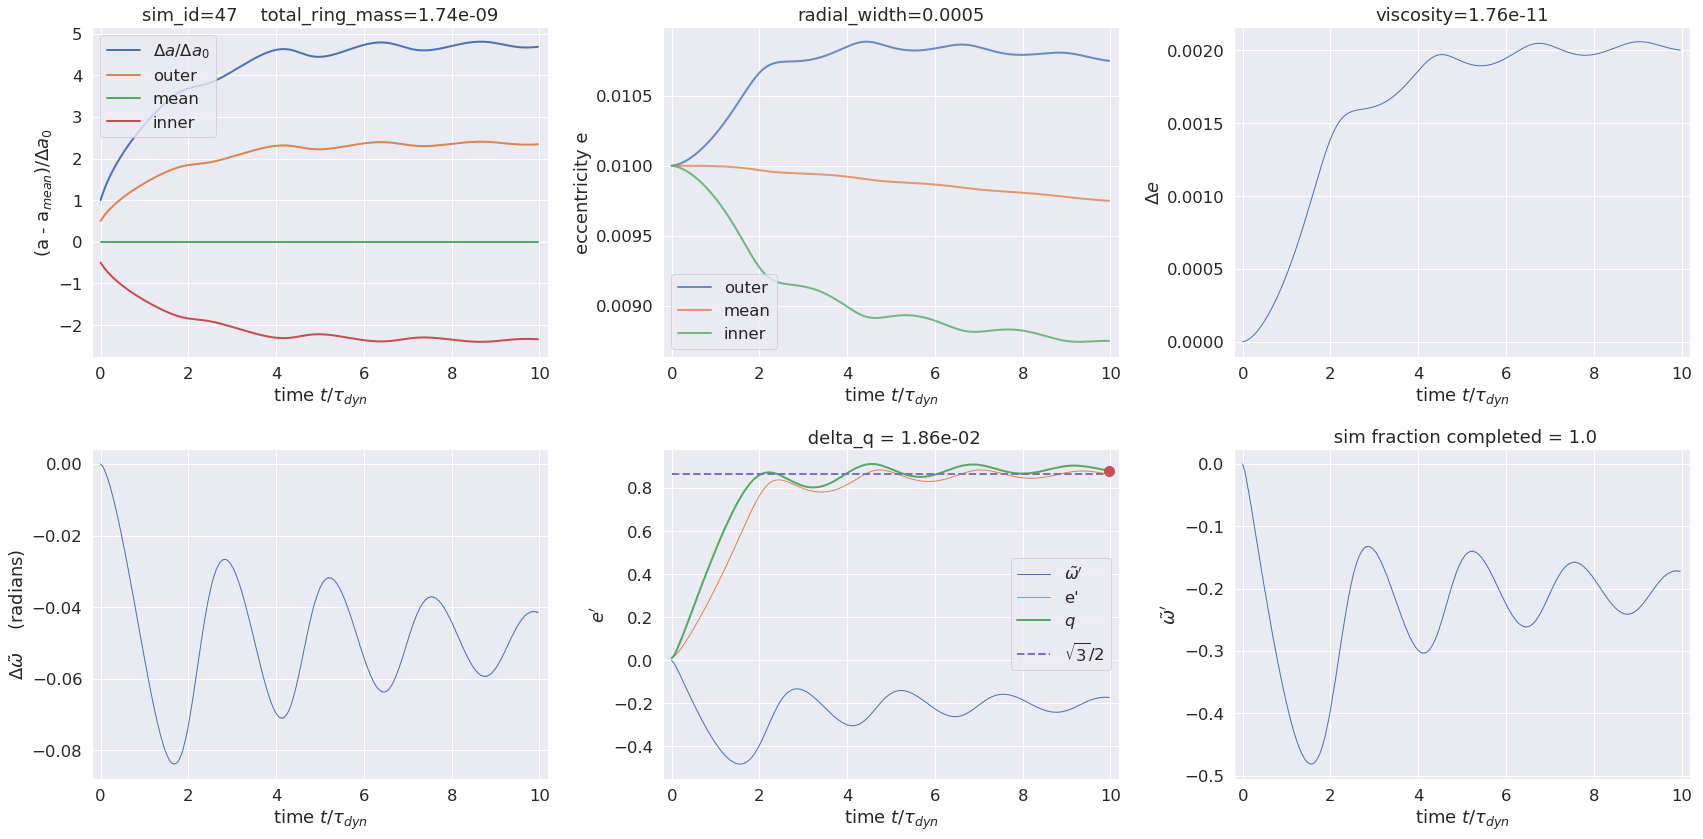

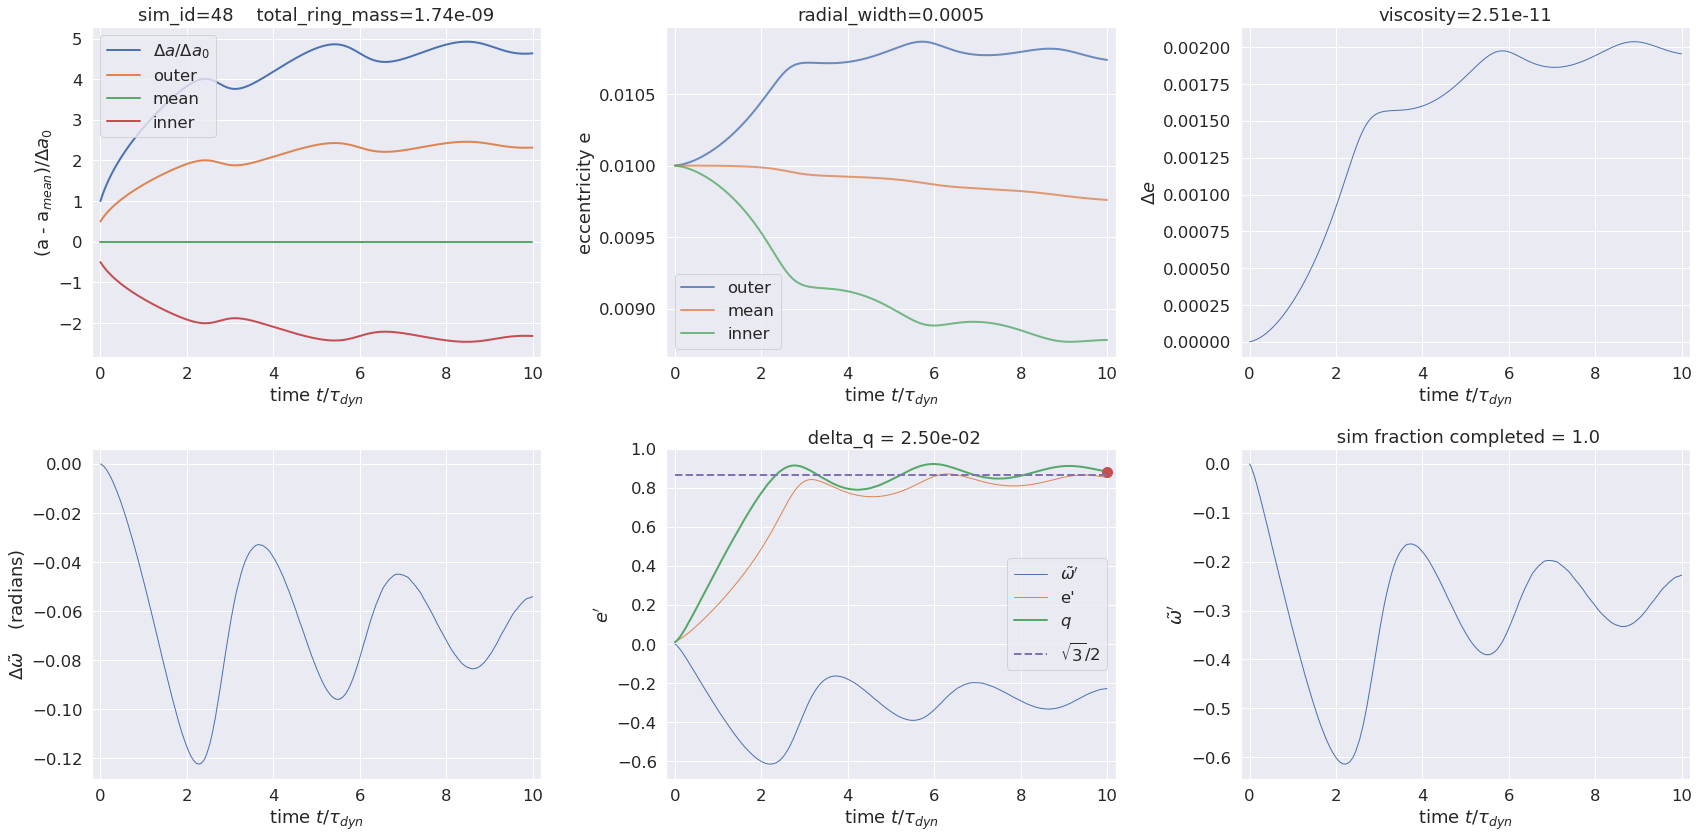

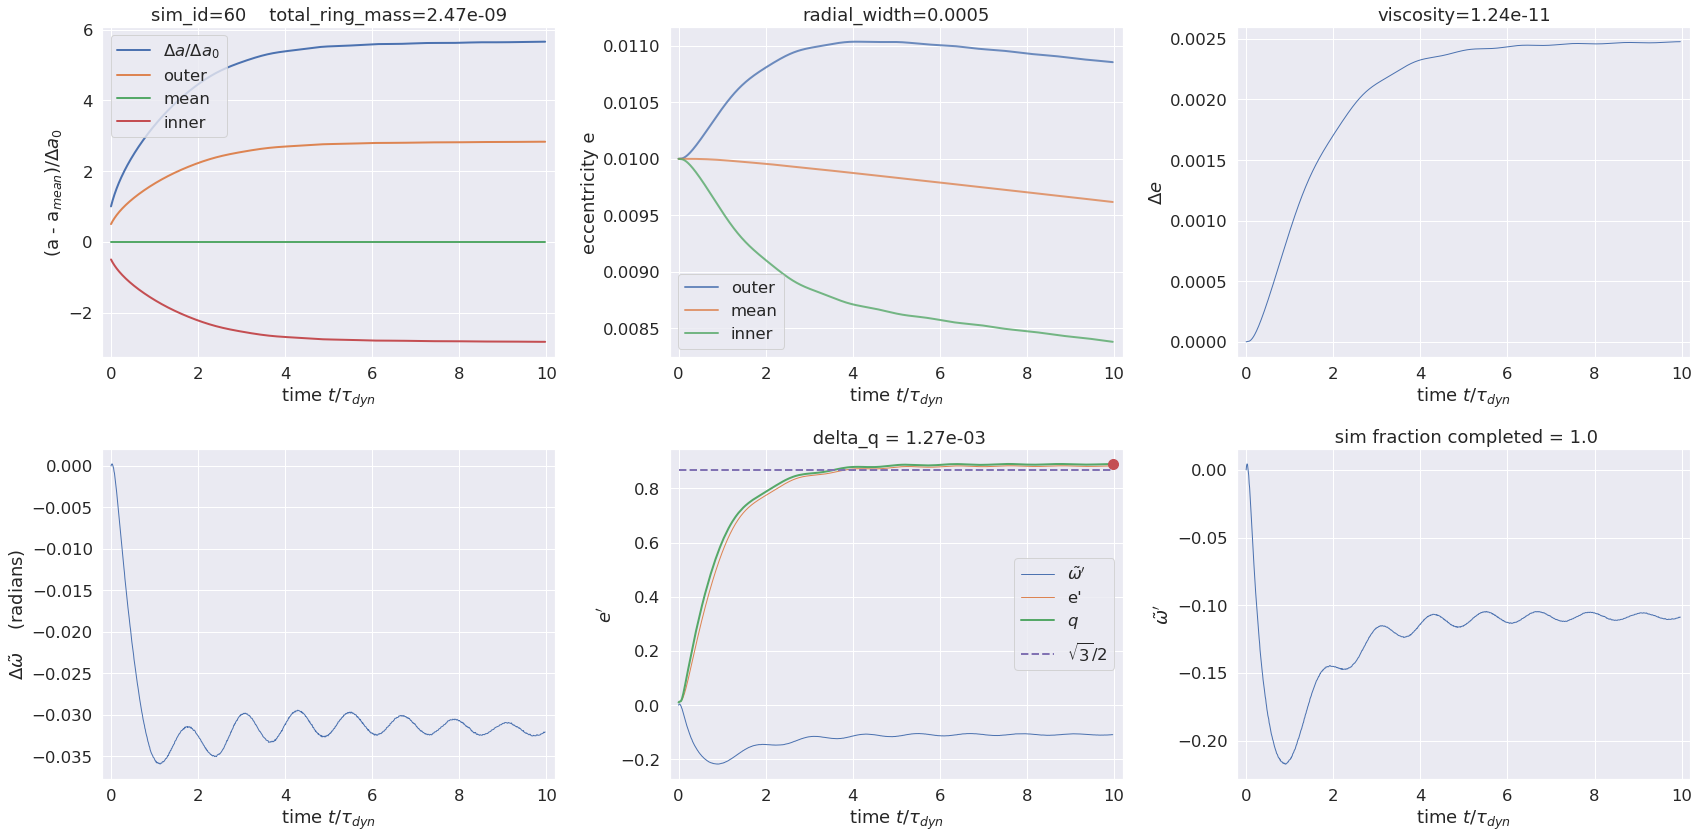

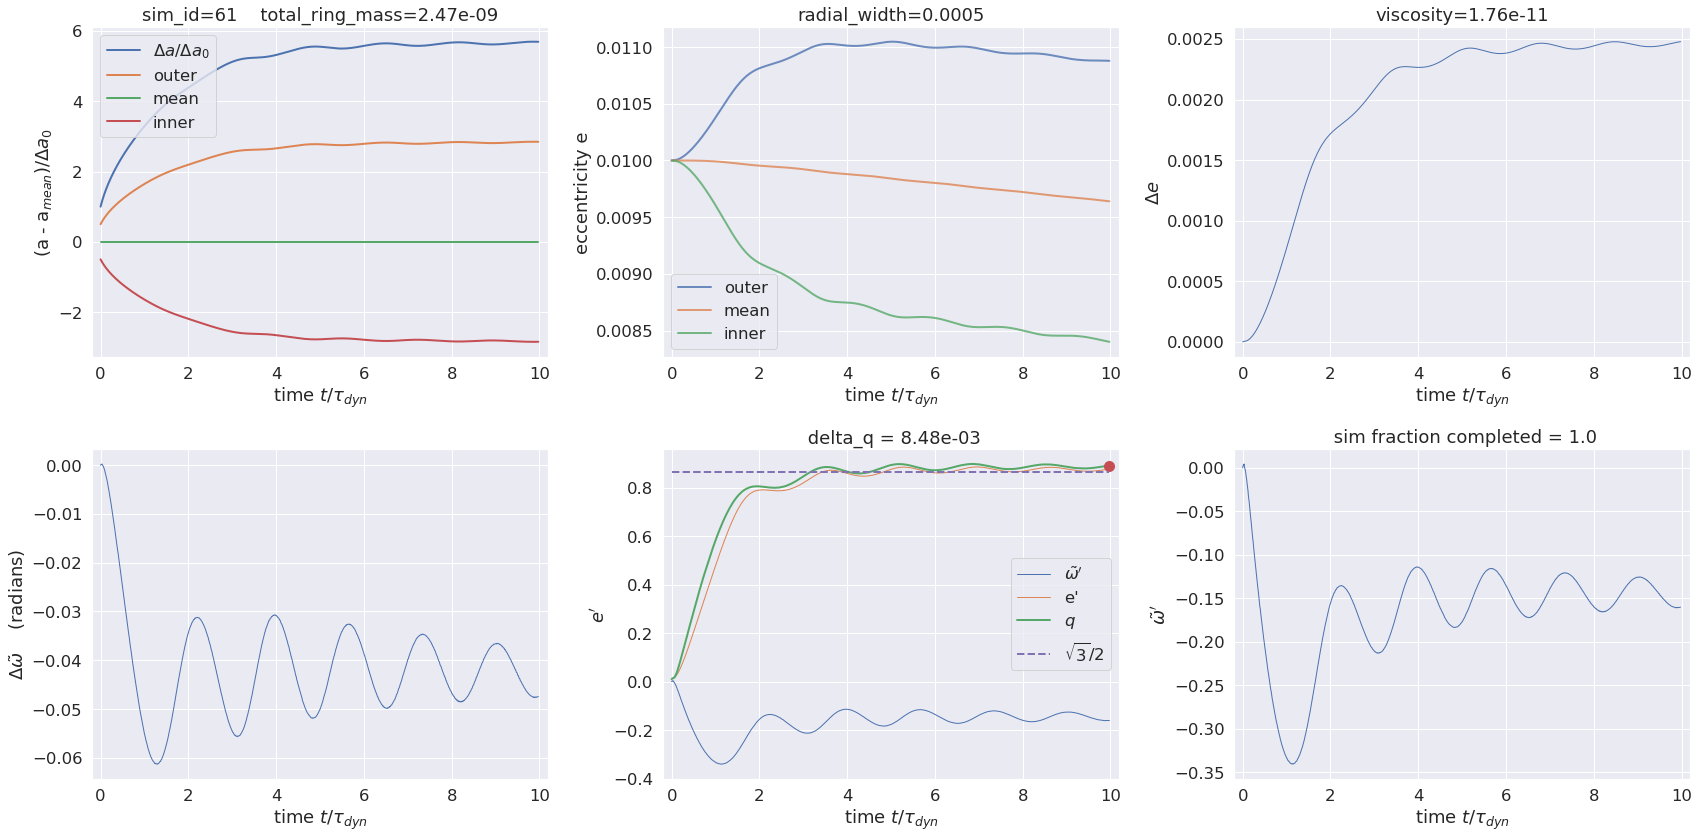

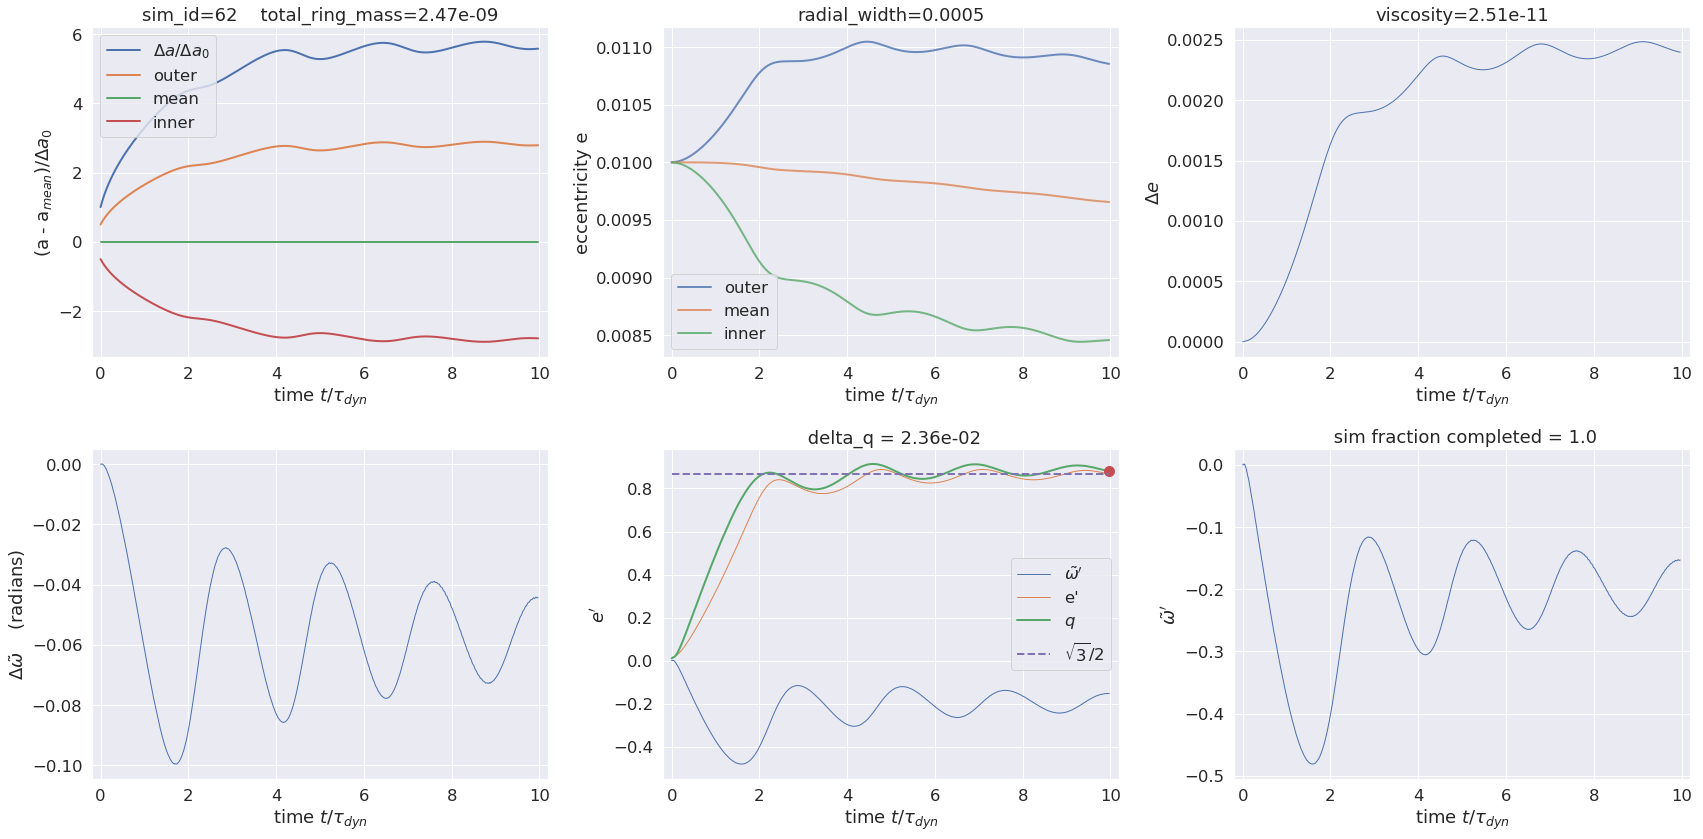

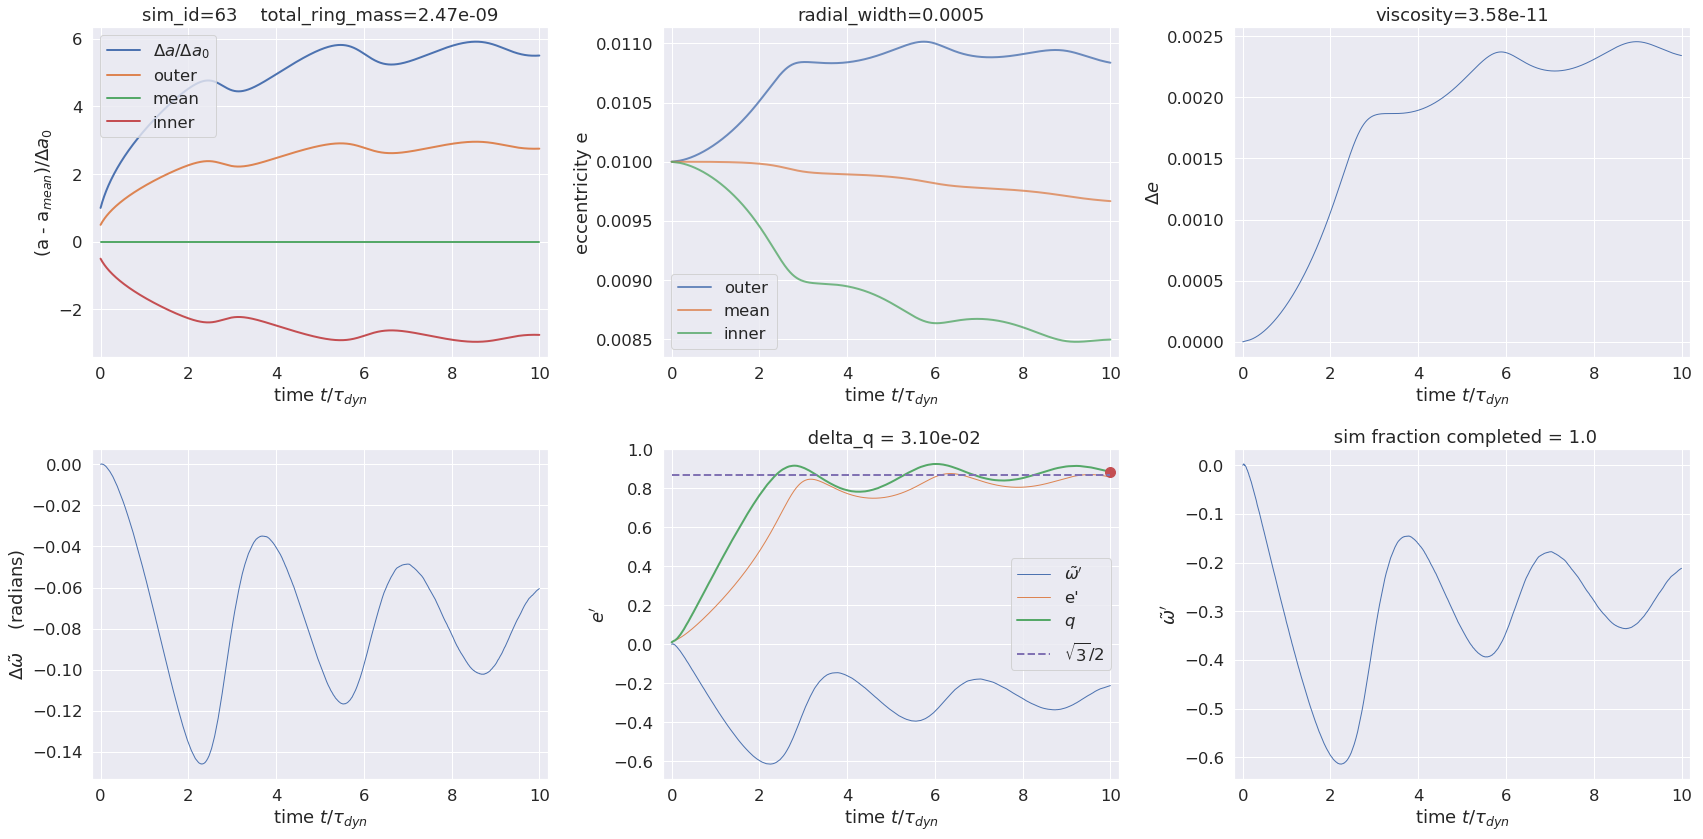

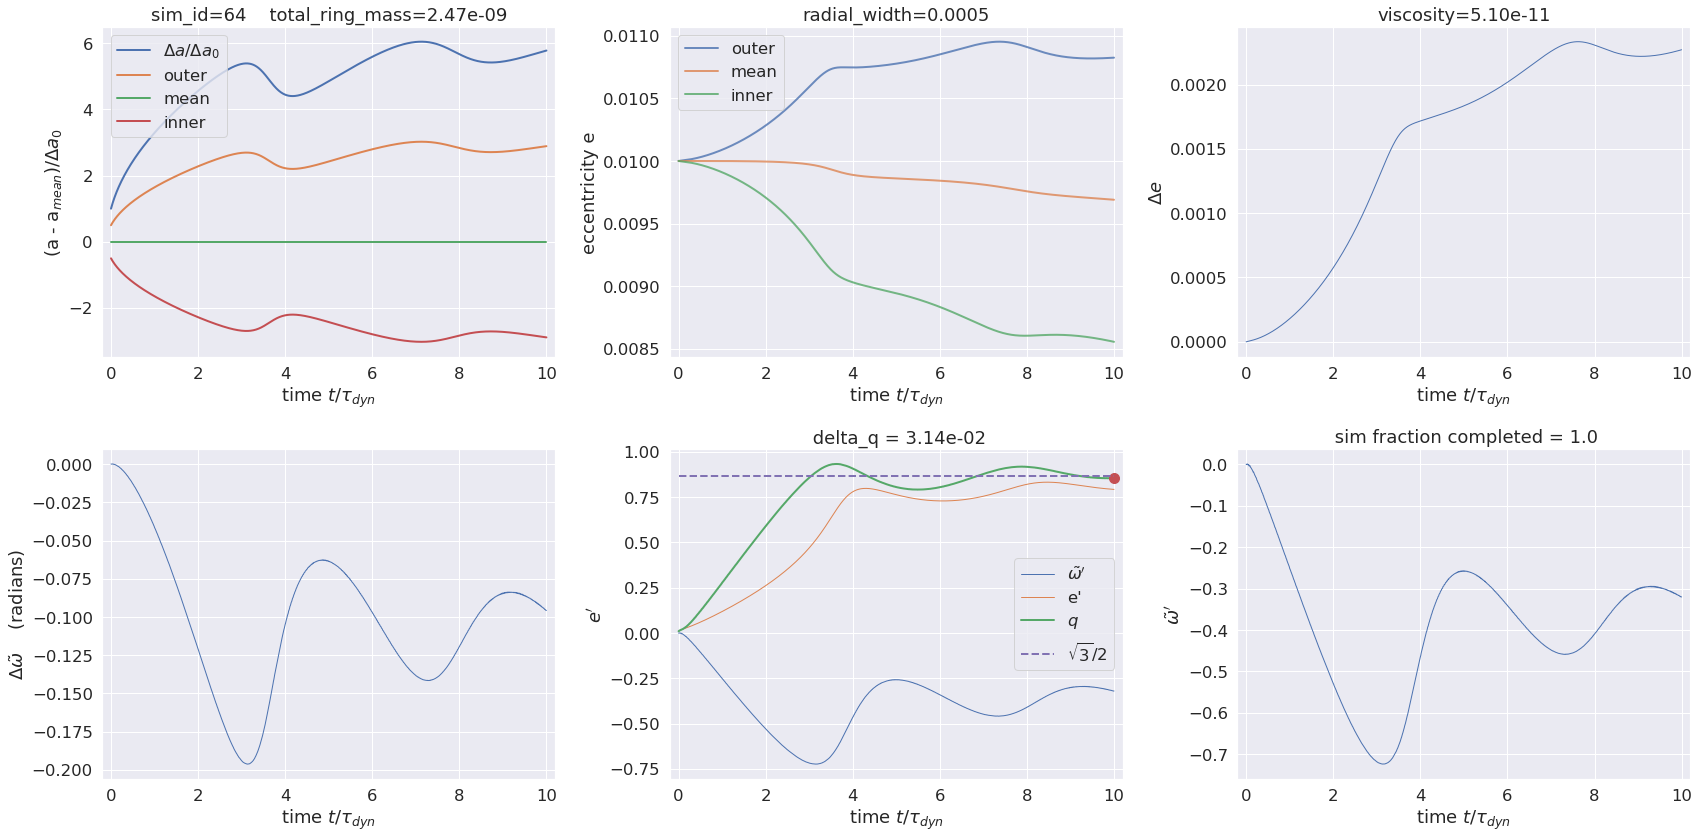

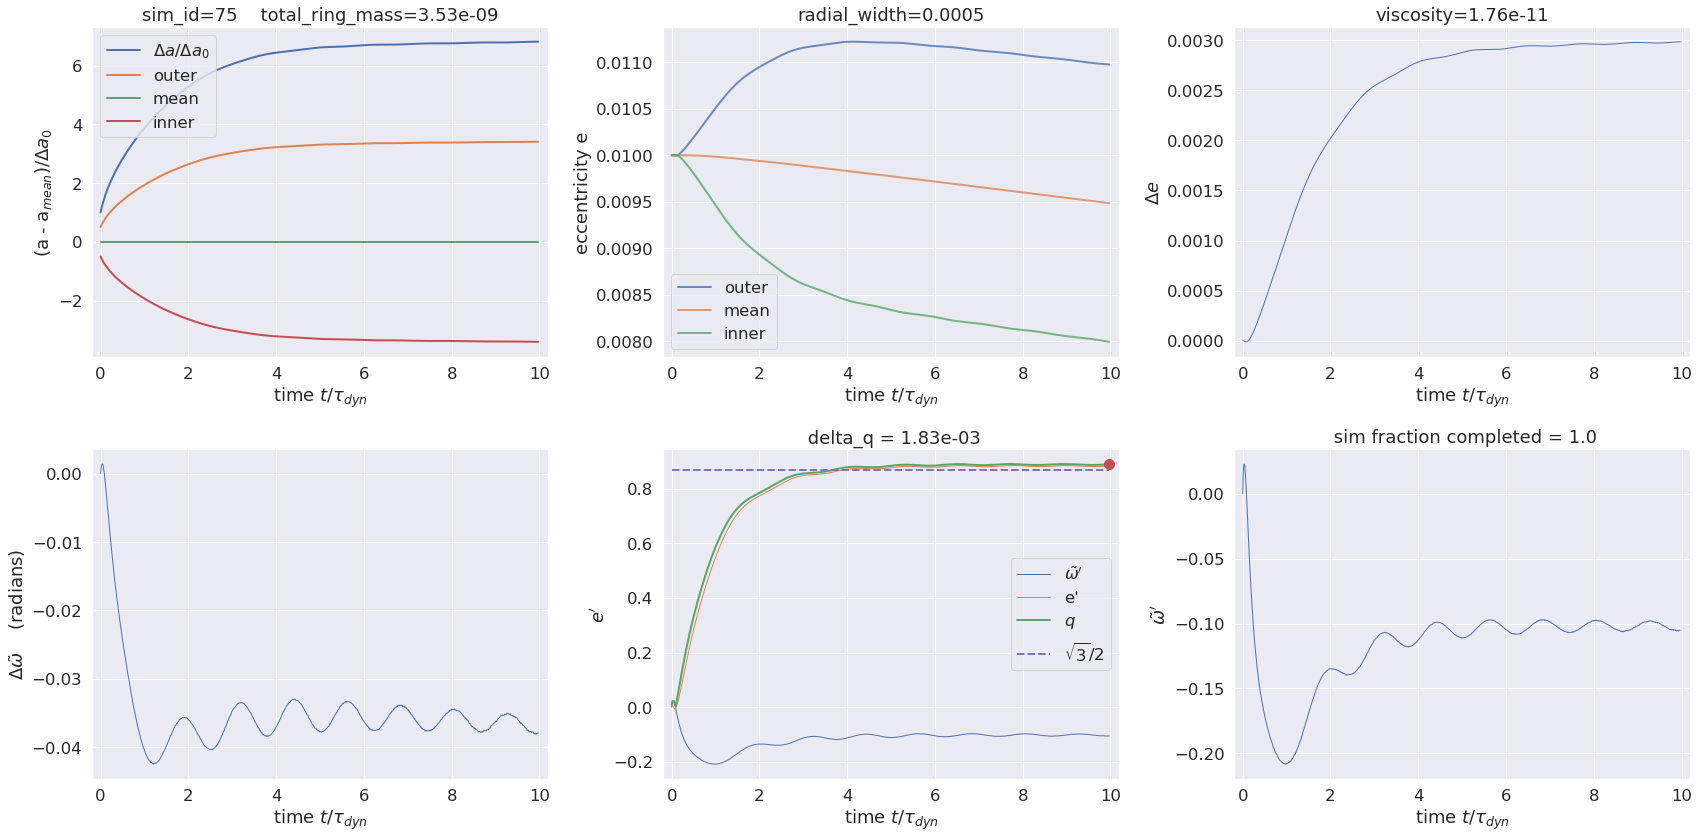

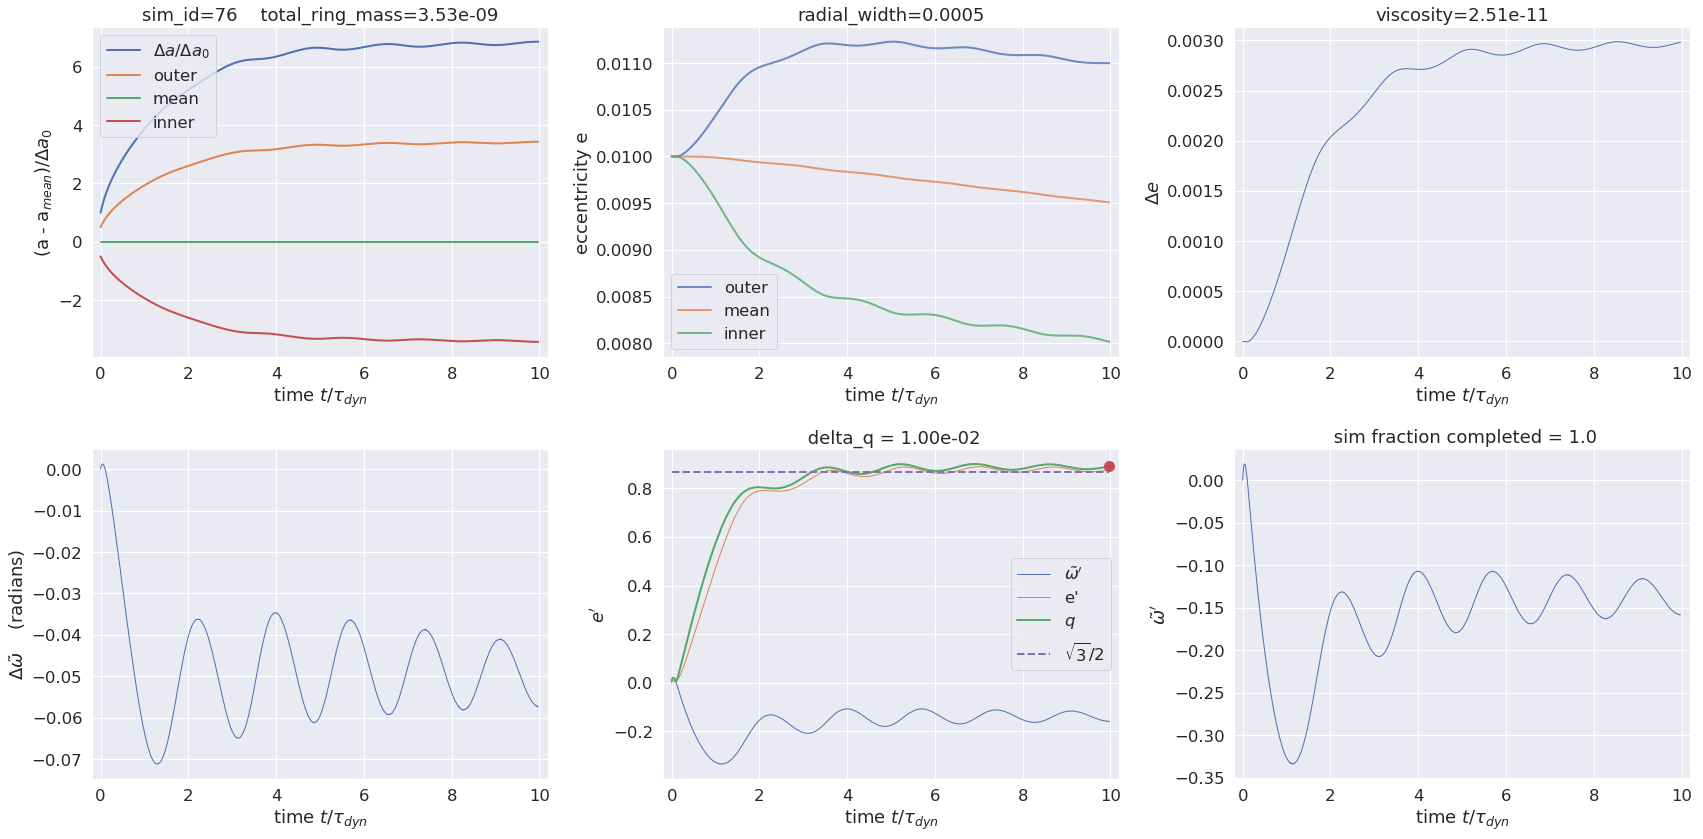

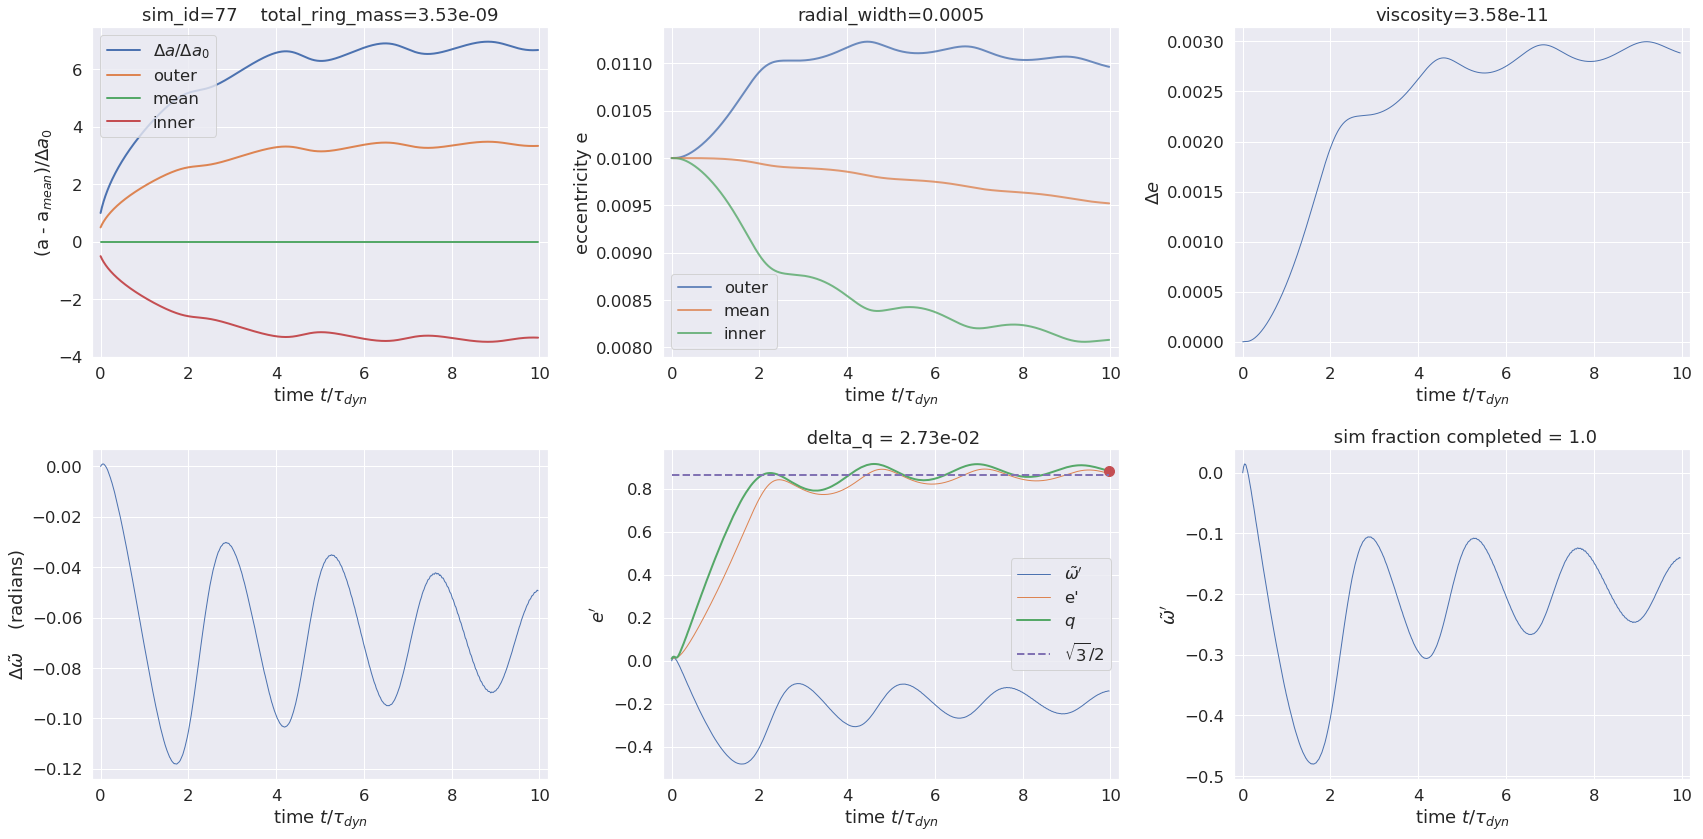

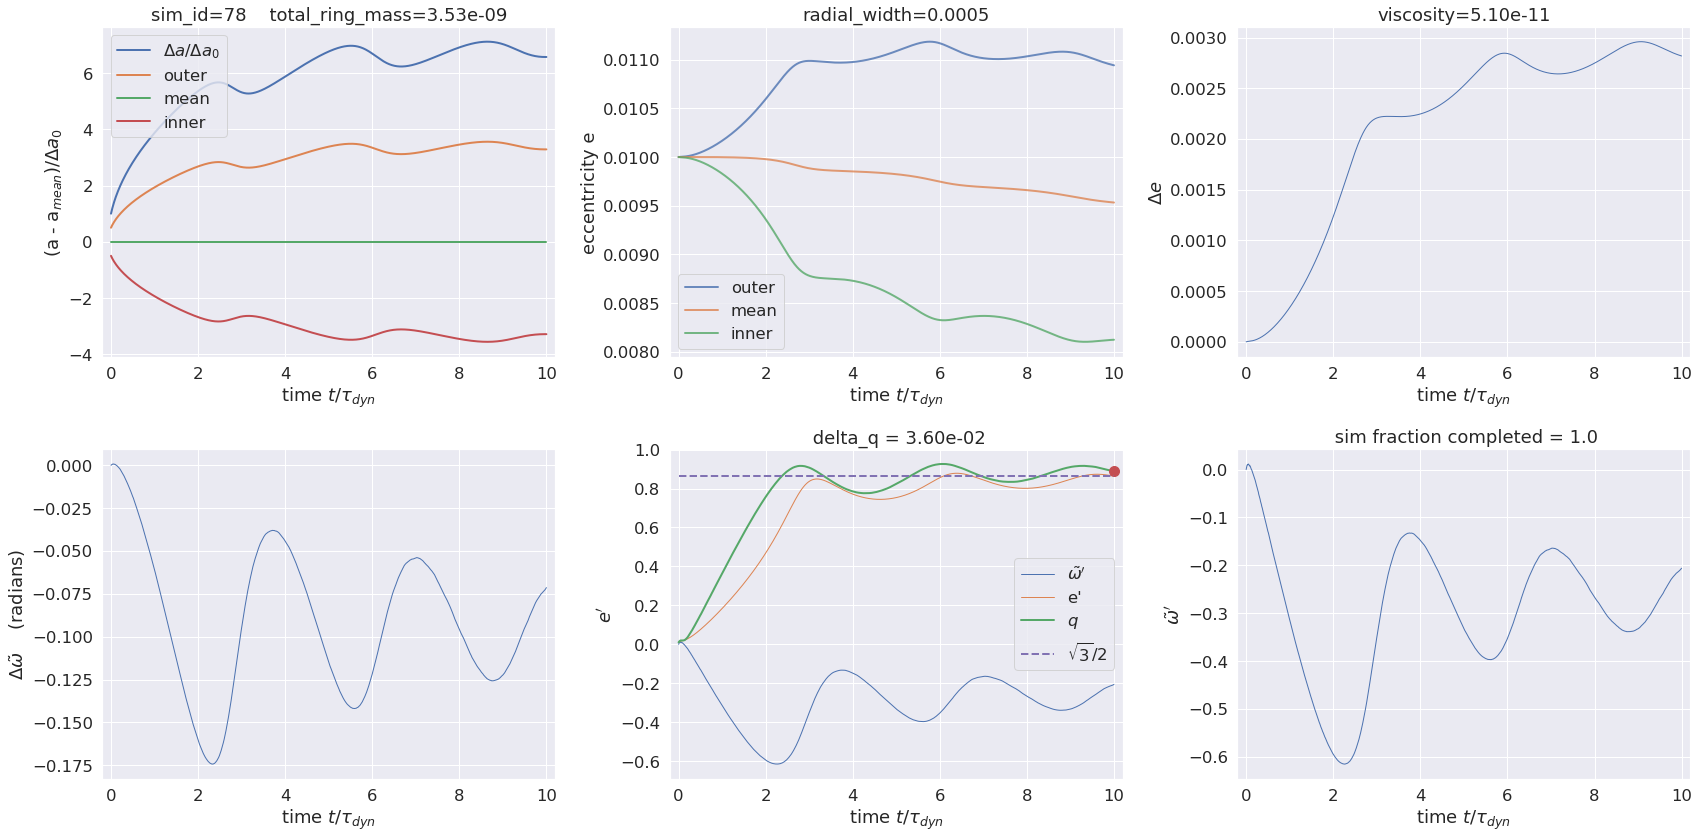

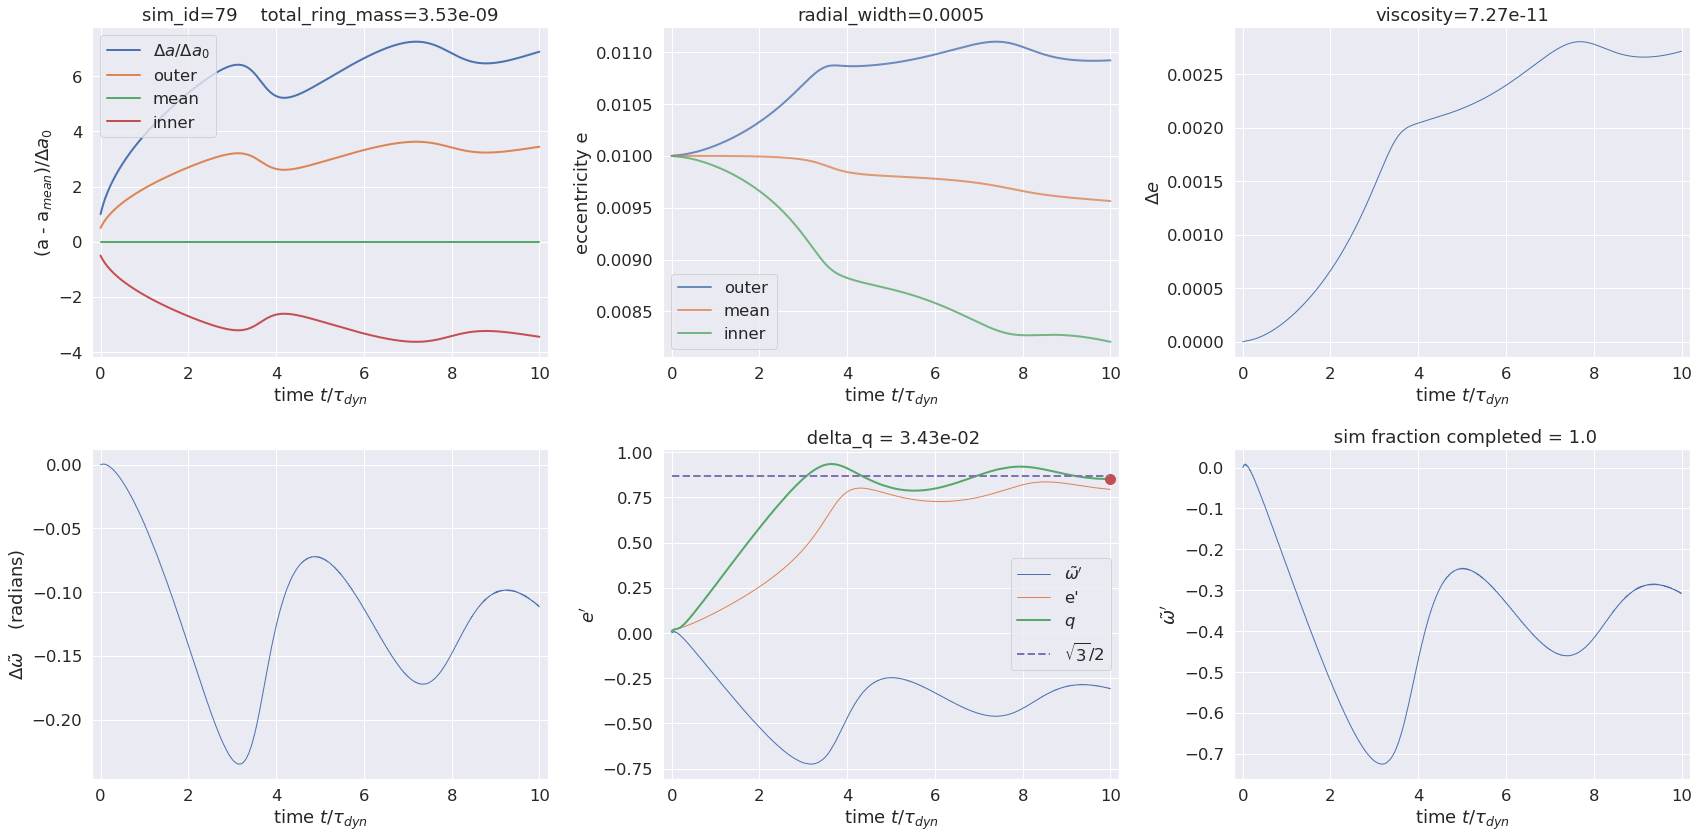

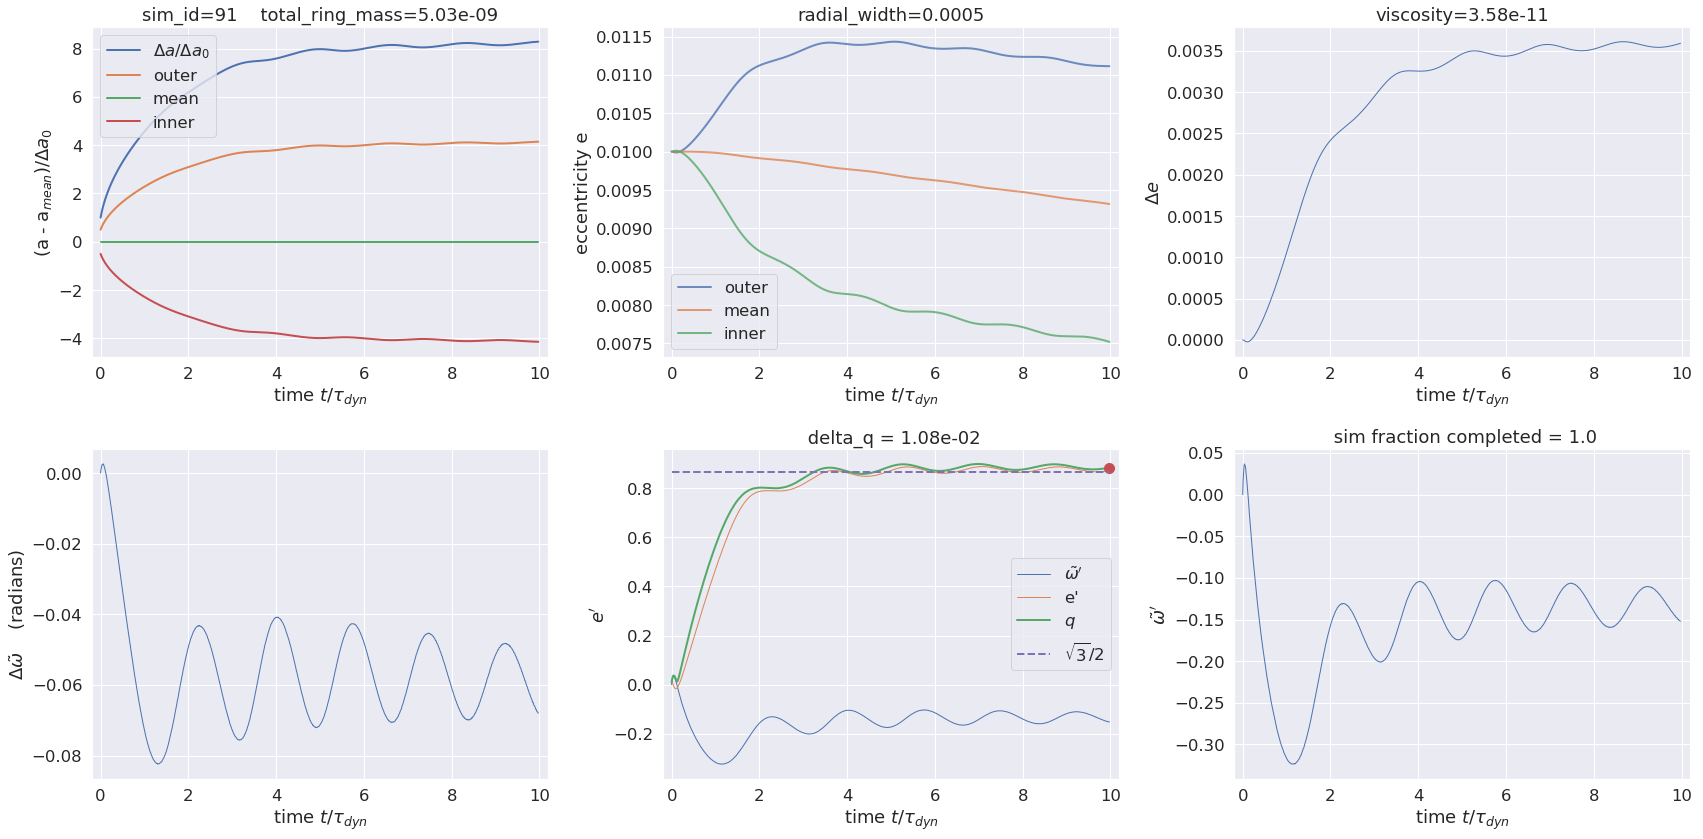

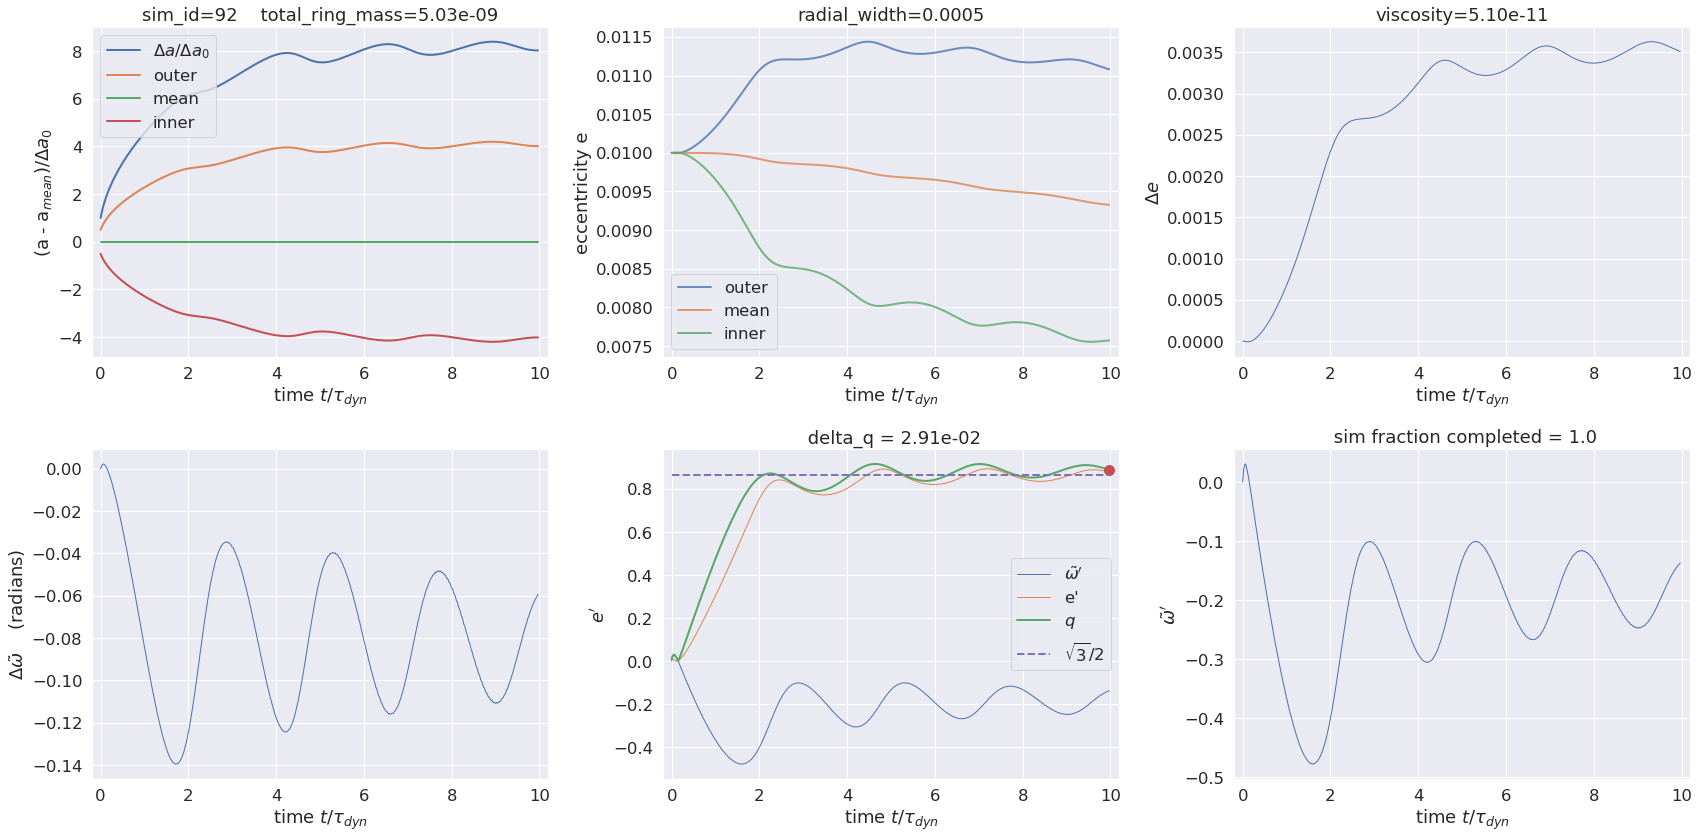

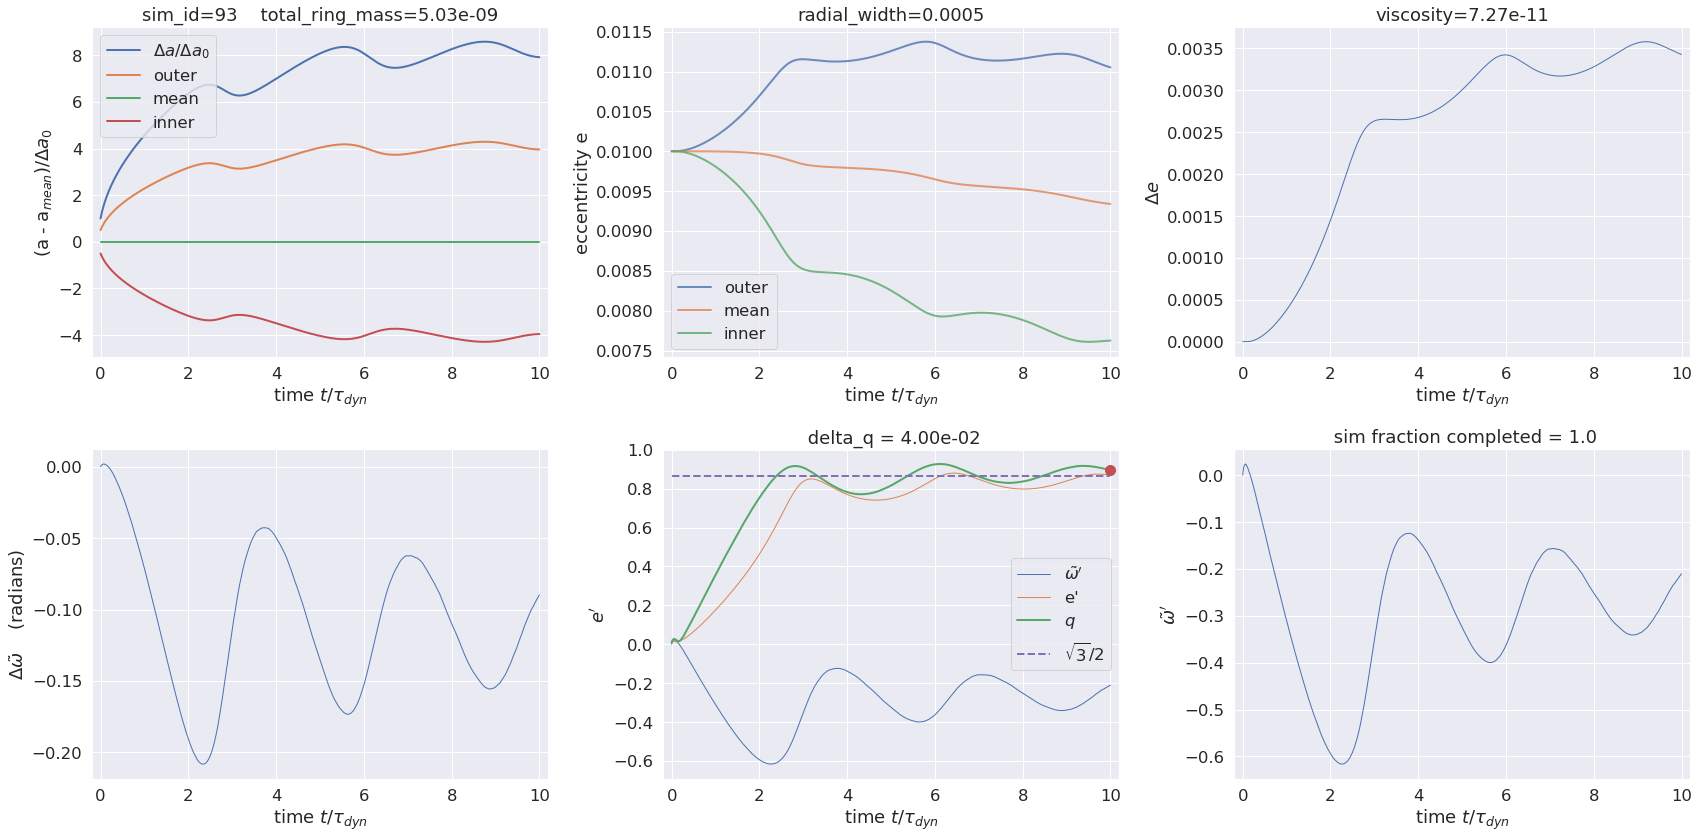

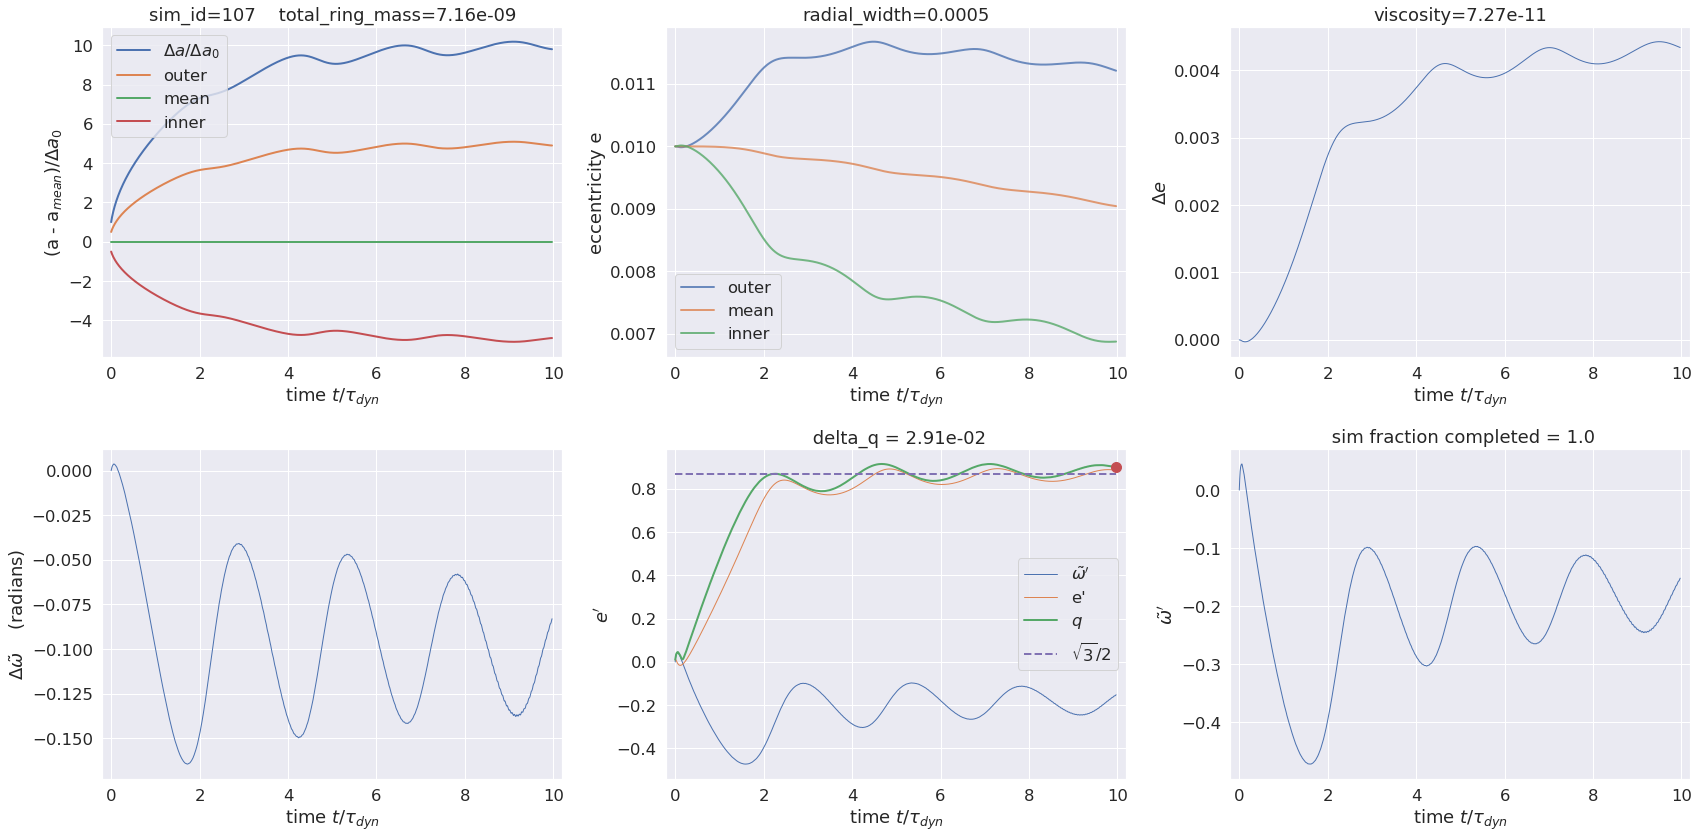

In [6]:
#generate grid of summary plots, for each sim that evolves to completion with low |wt_prime|
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    d['times_dynamical_max'] = int(times_dynamical.max())
    
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    da_init = da[0]
    
    #compute e_prime, wt_prime, q to lowest order, and H(q)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    idx = (times_dynamical > 0.8*times_dynamical.max())
    d['q'] = q[idx].mean()
    d['delta_q'] = 0.5*(q[idx].max() - q[idx].min())
    d['wt_prime'] = wt_prime[idx].mean()
    
    #report on sims that execute without crossing streamlines
    if ((current_timestep == expected_timestep) and (np.abs(d['wt_prime']) < d['q']/2)):

        if (debug):
            print 'path = ', path
            print 'total_ring_mass = ', total_ring_mass
            print 'radial_width = ', radial_width
            print 'shear_viscosity = ', shear_viscosity
            print 'dynamical_timescale = ', dynamical_timescale
            print 'current, expected timesteps = ', current_timestep, expected_timestep
            print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_dynamical
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + '{:.2e}'.format(total_ring_mass)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_dynamical
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + '{:.2e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_dynamical
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        if (streamline_crossing_timestep == None):
            p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        title = ' delta_q = ' + '{:.2e}'.format(d['delta_q'])
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        title = ' sim fraction completed = ' + str(current_timestep*1.0/expected_timestep)
        p = ax.set_title(title)

        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
    
    data += [d]
df = pd.DataFrame(data)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'times_dynamical_max', 
    'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'wt_prime', 'path']
df = df[cols].sort_values('sim_id').reset_index(drop=True)
df_results = df

In [7]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
df[idx]

sim_id  expected_timestep  current_timestep  \
0         0             329000            329000   
1         1             231000            231000   
2         2             162000            162000   
14       14             470000            470000   
15       15             329000            329000   
16       16             231000            231000   
17       17             162000            162000   
29       29             470000            470000   
30       30             330000            330000   
31       31             231000            231000   
32       32             162000            162000   
33       33             114000            114000   
44       44             470000            470000   
45       45             330000            330000   
46       46             231000            231000   
47       47             162000            162000   
48       48             114000            114000   
60       60             329000            329000   
61       61             231000            231000   
62       62             162000            162000   
63       63             114000            114000   
64       64              80000             80000   
75       75             329000            329000   
76       76             231000            231000   
77       77             162000            162000   
78       78             114000            114000   
79       79              80000             80000   
91       91             231000            231000   
92       92             162000            162000   
93       93             114000            114000   
107     107             162000            162000   

     streamline_crossing_timestep  times_dynamical_max  total_ring_mass  \
0                             NaN                    9     6.000000e-10   
1                             NaN                    9     6.000000e-10   
2                             NaN                    9     6.000000e-10   
14                            NaN                    9     8.550616e-10   
15                            NaN                    9     8.550616e-10   
16                            NaN                    9     8.550616e-10   
17                            NaN                    9     8.550616e-10   
29                            NaN                    9     1.218551e-09   
30                            NaN                   10     1.218551e-09   
31                            NaN                    9     1.218551e-09   
32                            NaN                    9     1.218551e-09   
33                            NaN                    9     1.218551e-09   
44                            NaN                    9     1.736560e-09   
45                            NaN                   10     1.736560e-09   
46                            NaN                    9     1.736560e-09   
47                            NaN                    9     1.736560e-09   
48                            NaN                    9     1.736560e-09   
60                            NaN                    9     2.474776e-09   
61                            NaN                    9     2.474776e-09   
62                            NaN                    9     2.474776e-09   
63                            NaN                    9     2.474776e-09   
64                            NaN                    9     2.474776e-09   
75                            NaN                    9     3.526810e-09   
76                            NaN                    9     3.526810e-09   
77                            NaN                    9     3.526810e-09   
78                            NaN                    9     3.526810e-09   
79                            NaN                    9     3.526810e-09   
91                            NaN                    9     5.026066e-09   
92                            NaN                    9     5.026066e-09   
93                            NaN                    9     5.026066e-09   
107            

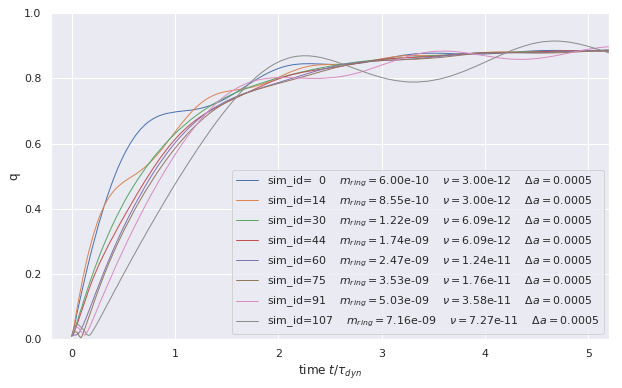

In [8]:
#for each total_ring_mass, plot q(t/t_dyn) for the sim whose viscosity yielded lowest delta_q
df = df_results
xlim = (-0.2, 5.2)
ylim = (0.0, 1.0)
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
total_ring_masses = df.total_ring_mass.sort_values().unique()
for total_ring_mass in total_ring_masses:
    #for each total_ring_mass, find the sim whose viscosity yields lowest delta_q
    idx = (df.current_timestep == df.expected_timestep) & (df.total_ring_mass == total_ring_mass) \
        & (df.wt_prime.abs() < df.q/2)
    dfs = df[idx]
    try:
        idx = dfs.delta_q.idxmin()
        dfss = dfs.loc[idx]
        path = dfss.path
        sim_id = dfss.sim_id
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
        dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0005)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot e_prime wt_prime and q versus time
        x = times_dynamical
        y = q
        label = 'sim_id=' + str(sim_id)
        if (sim_id < 10): label = 'sim_id=  ' + str(sim_id)
        label += r'    $m_{ring}=$' + '{:.2e}'.format(total_ring_mass)
        label += r'    $\nu=$' + '{:.2e}'.format(shear_viscosity)
        label += r'    $\Delta a =$' + str(radial_width)
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend()
    except:
        pass

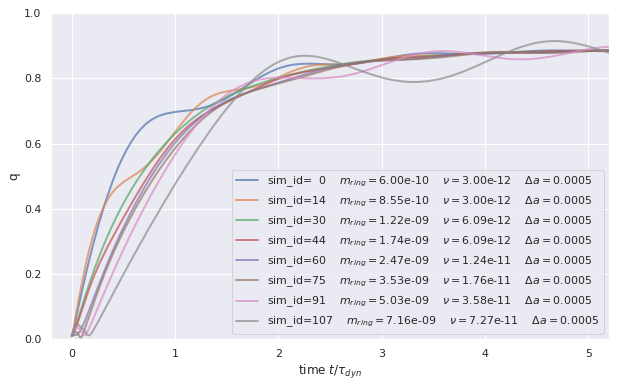

In [9]:
#confirm -0.33 power-law dempendance on radial_width by plotting q(t/t_dyn) for ringlet of constant mass & viscosity
df = df_results
sim_ids = [0, 14, 30, 44, 60, 75, 91, 107]
xlim = (-0.2, 5.2)
ylim = (0.0, 1.0)
idx = df.sim_id.isin(sim_ids)
df = df[idx]
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
#from helper_fns import *
#from libration import *
for idx, row in df.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #plot e_prime wt_prime and q versus time
    x = times_dynamical
    y = q
    label = 'sim_id=' + str(sim_id)
    if (sim_id < 10): label = 'sim_id=  ' + str(sim_id)
    label += r'    $m_{ring}=$' + '{:.2e}'.format(total_ring_mass)
    label += r'    $\nu=$' + '{:.2e}'.format(shear_viscosity)
    label += r'    $\Delta a =$' + str(radial_width)
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.7, label=label)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel('q')
    p = ax.set_xlim(xlim)
    p = ax.set_ylim(ylim)
    p = ax.legend()

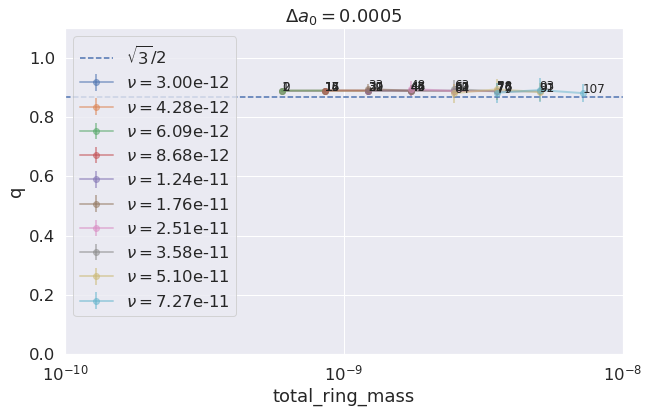

In [10]:
#plot q vs total_ring_mass, for each radial_width and shear_viscosity
df = df_results
shear_viscosities = df.shear_viscosity.sort_values().unique()
radial_widths = df.radial_width.sort_values().unique()
xlim = np.array([1.0e-10, 1.0e-8])
for radial_width in radial_widths:
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    xp = dfs.total_ring_mass
    yp = dfs.q
    for shear_viscosity in shear_viscosities:
        jdx = (dfs.shear_viscosity == shear_viscosity) & (dfs.wt_prime.abs() < dfs.q/2) \
            & (dfs.current_timestep == dfs.expected_timestep)
        dfss = dfs[jdx].sort_values('total_ring_mass')
        if (len(dfss) > 0):
            xp = dfss.total_ring_mass
            yp = dfss.q
            err = dfss.delta_q
            label = r'$\nu=$' + '{:.2e}'.format(shear_viscosity)
            p = ax.errorbar(xp, yp, err, marker='o', alpha=0.5, markersize=6, linestyle='-', linewidth=2, label=label)
            id_str = dfss.sim_id.astype(str).values.tolist()
            xy = zip(xp, yp)
            for jdx, s in enumerate(id_str):
                p = ax.annotate(s, xy[jdx], fontsize=12)
    xp = xlim
    yp = xp*0 + np.sqrt(3)/2
    p = ax.plot(xp, yp, linestyle='dashed', label=r'$\sqrt{3}/2$')
    title = r'$\Delta a_0=$' + str(radial_width)
    p = ax.set_title(title)
    p = ax.set_xlabel('total_ring_mass')
    p = ax.set_ylabel('q')
    p = ax.set_xscale('log')
    p = ax.legend()
    p = ax.set_xlim(xlim)
    p = ax.set_ylim(0, 1.1)

In [11]:
print 'total_ring_mass = ', df.total_ring_mass.unique()
print 'radial_width = ', df.radial_width.unique()
print 'shear_viscosity = ', df.shear_viscosity.unique()

total_ring_mass =  [6.00000000e-10 8.55061602e-10 1.21855057e-09 1.73655967e-09
 2.47477583e-09 3.52680964e-09 5.02606584e-09 7.16265985e-09
 1.02075257e-08 1.45467721e-08 2.07306438e-08 2.95432958e-08
 4.21022297e-08 6.00000000e-08]
radial_width =  [0.0005]
shear_viscosity =  [3.00000000e-12 4.27530801e-12 6.09275286e-12 8.68279837e-12
 1.23738791e-11 1.76340482e-11 2.51303292e-11 3.58132993e-11
 5.10376284e-11 7.27338605e-11 1.03653219e-10 1.47716479e-10
 2.10511149e-10 3.00000000e-10]


In [12]:
(1.0e-8)/(5.0e-10)

20.0

In [13]:
(1.0e-10)/(5.0e-13)

200.0